# Analysis of the New Geometry

#### Importing

In [1]:
#%%IMPORTING
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import datetime
import matplotlib.colors as colors
divnorm = colors.TwoSlopeNorm(vcenter=0)
plt.rcParams.update({'font.size': 18})
from functions.loading_and_processing_data import loadMITgcmData,loadTimeSeriesData, detrend_and_average_MITgcmData
from functions.composite_maps import createCompositeMap, createVelocityCompositeMap, defineEvents, findEvents

In [2]:
import sys
sys.path.append('/data/hpcdata/users/grejan/mitgcm/') #Make sure we can also import Kaitlins code.
from mitgcm_python_master.grid import Grid
from mitgcm_python_master.plot_utils.labels import slice_axes, latlon_axes
from mitgcm_python_master.utils import convert_ismr
gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/'
grid = Grid(gp)

/users/kaight/MITgcm/utils/python/MITgcmutils/MITgcmutils/netcdf.py:330: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if hasattr(self, 'mode') and self.mode is 'w':
/users/kaight/MITgcm/utils/python/MITgcmutils/MITgcmutils/netcdf.py:705: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if typecode is not 'c':


#### Loading and Process the Data

In [3]:
#Load time series for specific members
members=[4,6,10,11,12]

In [4]:
%%capture  
#This is to get rid of the printed output.

#Read Time Series
#The old time series are now split over a range of different files....

#Old time series
full=loadTimeSeriesData(filename='timeseries_final', members=members, kind='old')
full['time']=full.indexes['time'].to_datetimeindex()
full=full.sortby('time')
full=full.sel(time=slice('1920', '2013'))

forcing=loadTimeSeriesData(filename='timeseries_forcing', members=members, kind='old')
forcing['time']=forcing.indexes['time'].to_datetimeindex()
forcing=forcing.sel(time=slice('1920', '2013'))

PACEmelt=loadTimeSeriesData(filename='timeseries_melting', members=members, kind='timeseries')
PACEmelt['time']=PACEmelt.indexes['time'].to_datetimeindex()
_, index = np.unique(PACEmelt['time'], return_index=True)
PACEmelt=PACEmelt.isel(time=index)
PACEmelt=PACEmelt.sel(time=slice('1920', '2013'))

salt=loadTimeSeriesData(filename='timeseries_salt', members=members, kind='timeseries')
salt['time']=salt.indexes['time'].to_datetimeindex()
salt=salt.sortby('time')
salt=salt.sel(time=slice('1920', '2013'))

OHC=loadTimeSeriesData(filename='timeseries_ohc', members=members, kind='old')
OHC['time']=OHC.indexes['time'].to_datetimeindex()
OHC=OHC.sortby('time')
OHC=OHC.sel(time=slice('1920', '2013'))

#New time series
GEO=loadTimeSeriesData(filename='timeseries_full', members=members, kind='timeseries', PACE=False)
GEO['time']=GEO.indexes['time'].to_datetimeindex()
_, index = np.unique(GEO['time'], return_index=True)
GEO=GEO.isel(time=index)
GEO=GEO.sel(time=slice('1920', '2013'))

In [5]:
#Detrend everything
GEO_dt=GEO.copy()
full_dt=full.copy()
forcing_dt=full.copy()
PACEmelt_dt=PACEmelt.copy()
salt_dt=salt.copy()
OHC_dt=OHC.copy()

for j in GEO_dt.variables:
    GEO_dt[j]=detrend_and_average_MITgcmData(GEO_dt, var=j, window=1)
for j in full_dt.variables:
    full_dt[j]=detrend_and_average_MITgcmData(full_dt, var=j, window=1)
for j in PACEmelt_dt.variables:
    PACEmelt_dt[j]=detrend_and_average_MITgcmData(PACEmelt_dt, var=j, window=1)
for j in forcing_dt.variables:
    forcing_dt[j]=detrend_and_average_MITgcmData(forcing_dt, var=j, window=1)
for j in salt_dt.variables:
    salt_dt[j]=detrend_and_average_MITgcmData(salt_dt, var=j, window=1)
for j in OHC_dt.variables:
    OHC_dt[j]=detrend_and_average_MITgcmData(OHC_dt, var=j, window=1)

#Combined Sea Ice Flux
SI=(forcing['amundsen_shelf_seaice_melt']+forcing['amundsen_shelf_seaice_freeze'])
SI_dt=detrend_and_average_MITgcmData(SI.to_dataset(name='seaice'), var='seaice', window=1)

GEOSI=(GEO['amundsen_shelf_seaice_melt']+GEO['amundsen_shelf_seaice_freeze'])
GEOSI_dt=detrend_and_average_MITgcmData(GEOSI.to_dataset(name='seaice'), var='seaice', window=1)

In [8]:
%%capture  
#This is to get rid of the printed output.

#LOAD SPATIAL MAPS
#First for Ice Melt
SHI=loadMITgcmData('SHIfwFlx', members=members, kind='maps')
GEOSHI=loadMITgcmData('GEO_SHIfwFlx', members=members, kind='maps')

#Remove the grounded ice and select relevant subdomain
SHI=SHI.where(GEOSHI!=0)
GEOSHI=GEOSHI.where(GEOSHI!=0)
SHI=SHI.sel(XC=slice(245, 263), YC=slice(-75.5, -73.2), time=slice('1920', '2013'))
GEOSHI=GEOSHI.sel(XC=slice(245, 263), YC=slice(-75.5, -73.2), time=slice('1920', '2013'))

SHI['SHIfwFlx']=convert_ismr(SHI['SHIfwFlx'])
GEOSHI['SHIfwFlx']=convert_ismr(GEOSHI['SHIfwFlx'])

#Detrend the data
GEOSHI_dt=detrend_and_average_MITgcmData(GEOSHI, 'SHIfwFlx', window=1)
SHI_dt=detrend_and_average_MITgcmData(SHI, 'SHIfwFlx', window=1)


In [9]:
#Now for Ocean State
#First Temperature and Salinity
THETA=loadMITgcmData('new2_amundsen_shelf_temp_200to700', members=members, kind='old')
GEOTHETA=loadMITgcmData('GEO_THETA_averaged_-700to-200', members=members, kind='maps')

SALT=loadMITgcmData('SALT_averaged_-700to-200', members=members, kind='maps')
GEOSALT=loadMITgcmData('GEO_SALT_averaged_-700to-200', members=members, kind='maps')

#Remove grounded ice
THETA=THETA.where(GEOTHETA!=0)
SALT=SALT.where(GEOSALT!=0)



Loading number:3
../data/new2_amundsen_shelf_temp_200to700_ens4.nc
Loading number:5
../data/new2_amundsen_shelf_temp_200to700_ens6.nc
Loading number:9
../data/new2_amundsen_shelf_temp_200to700_ens10.nc
Loading number:10
../data/new2_amundsen_shelf_temp_200to700_ens11.nc
Loading number:11
../data/new2_amundsen_shelf_temp_200to700_ens12.nc
Loading number:3
../02_data/maps/GEO_THETA_averaged_-700to-200_ens4.nc
Loading number:5
../02_data/maps/GEO_THETA_averaged_-700to-200_ens6.nc
Loading number:9
../02_data/maps/GEO_THETA_averaged_-700to-200_ens10.nc
Loading number:10
../02_data/maps/GEO_THETA_averaged_-700to-200_ens11.nc
Loading number:11
../02_data/maps/GEO_THETA_averaged_-700to-200_ens12.nc
Loading number:3
../02_data/maps/SALT_averaged_-700to-200_ens4.nc
Loading number:5
../02_data/maps/SALT_averaged_-700to-200_ens6.nc
Loading number:9
../02_data/maps/SALT_averaged_-700to-200_ens10.nc
Loading number:10
../02_data/maps/SALT_averaged_-700to-200_ens11.nc
Loading number:11
../02_data/maps

In [10]:
#Second, velocity
UVEL=loadMITgcmData('UVEL_bottom100m_averaged', members=[4,6,10,11,12], kind='maps')
GEOUVEL=loadMITgcmData('GEO_UVEL_bottom100m_averaged', members=[4, 6, 10,11,12], kind='maps')

VVEL=loadMITgcmData('VVEL_bottom100m_averaged', members=[4,6,10,11,12], kind='maps')
GEOVVEL=loadMITgcmData('GEO_VVEL_bottom100m_averaged', members=[4, 6,10,11,12], kind='maps')

GEOUVEL=GEOUVEL.sel(time=slice('1920','2013'))
GEOVVEL=GEOVVEL.sel(time=slice('1920','2013'))

#Interpolate velocities to same position.
UVEL=UVEL.rename({'XG':'XC'})
GEOUVEL=GEOUVEL.rename({'XG':'XC'})

VVEL=VVEL.rename({'YG':'YC'})
GEOVVEL=GEOVVEL.rename({'YG':'YC'})
                            
UVEL=UVEL.interp(XC=THETA.XC)
GEOUVEL=GEOUVEL.interp(XC=THETA.XC)
                        
VVEL=VVEL.interp(YC=THETA.YC)
GEOVVEL=GEOVVEL.interp(YC=THETA.YC)

#Compute velocity norm
GEOVEL=xr.DataArray(data=GEOUVEL['UVEL'].values**2+GEOVVEL['VVEL'].values**2, dims=['ens','time', 'YC', 'XC'],
                    coords=dict(ens=GEOUVEL.ens, time=GEOUVEL.time, XC=GEOUVEL.XC, YC=GEOUVEL.YC))
VEL=xr.DataArray(data=UVEL['UVEL'].values**2+VVEL['VVEL'].values**2, dims=['ens','time', 'YC', 'XC'],
                    coords=dict(ens=UVEL.ens, time=UVEL.time, XC=UVEL.XC, YC=UVEL.YC))

#Remove Grounded Ice
GEOVEL=GEOVEL.where(GEOVEL!=0)
VEL=VEL.where(GEOVEL!=0)

Loading number:3
../02_data/maps/UVEL_bottom100m_averaged_ens4.nc
Loading number:5
../02_data/maps/UVEL_bottom100m_averaged_ens6.nc
Loading number:9
../02_data/maps/UVEL_bottom100m_averaged_ens10.nc
Loading number:10
../02_data/maps/UVEL_bottom100m_averaged_ens11.nc
Loading number:11
../02_data/maps/UVEL_bottom100m_averaged_ens12.nc
Loading number:3
../02_data/maps/GEO_UVEL_bottom100m_averaged_ens4.nc
Loading number:5
../02_data/maps/GEO_UVEL_bottom100m_averaged_ens6.nc
Loading number:9
../02_data/maps/GEO_UVEL_bottom100m_averaged_ens10.nc
Loading number:10
../02_data/maps/GEO_UVEL_bottom100m_averaged_ens11.nc
Loading number:11
../02_data/maps/GEO_UVEL_bottom100m_averaged_ens12.nc
Loading number:3
../02_data/maps/VVEL_bottom100m_averaged_ens4.nc
Loading number:5
../02_data/maps/VVEL_bottom100m_averaged_ens6.nc
Loading number:9
../02_data/maps/VVEL_bottom100m_averaged_ens10.nc
Loading number:10
../02_data/maps/VVEL_bottom100m_averaged_ens11.nc
Loading number:11
../02_data/maps/VVEL_bott

/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing metho

In [11]:
#Now Read Slices
dataT=loadMITgcmData(filename='theta_S72-5', members=members, kind='old') #Temperature was still preprocessed in the old way
dataS=loadMITgcmData(filename='SALT_S72-5', members=members, kind='slices')
dataV=loadMITgcmData(filename='VVEL_S72-5', members=members, kind='slices')

GEOT=loadMITgcmData(filename='GEO_THETA_S72-5', members=members, kind='slices')
GEOS=loadMITgcmData(filename='GEO_SALT_S72-5', members=members, kind='slices')
GEOV=loadMITgcmData(filename='GEO_VVEL_S72-5', members=members, kind='slices')

#Remove Grounded Ice
dataT=dataT.where(dataT!=0)
GEOT=GEOT.where(GEOT!=0)

dataS=dataS.where(dataS!=0)
GEOS=GEOS.where(GEOS!=0)

dataV=dataV.where(dataV!=0)
GEOV=GEOV.where(GEOV!=0)

#Compute Mean States
GEOTmean=GEOT['THETA'].mean(dim='ens')\
              .sel(time=slice('1920', '2013')).mean(dim='time')
dataTmean=dataT['THETA'].mean(dim='ens')\
              .sel(time=slice('1920', '2013')).mean(dim='time')

GEOSmean=GEOS['SALT'].mean(dim='ens')\
              .sel(time=slice('1920', '2013')).mean(dim='time')
dataSmean=dataS['SALT'].mean(dim='ens')\
              .sel(time=slice('1920', '2013')).mean(dim='time')

GEOVmean=GEOV['VVEL'].mean(dim='ens')\
              .sel(time=slice('1920', '2013')).mean(dim='time')
dataVmean=dataV['VVEL'].mean(dim='ens')\
              .sel(time=slice('1920', '2013')).mean(dim='time')

Loading number:3
../data/theta_S72-5_ens4.nc
Loading number:5
../data/theta_S72-5_ens6.nc
Loading number:9
../data/theta_S72-5_ens10.nc
Loading number:10
../data/theta_S72-5_ens11.nc
Loading number:11
../data/theta_S72-5_ens12.nc
Loading number:3
../02_data/slices/SALT_S72-5_ens4.nc
Loading number:5
../02_data/slices/SALT_S72-5_ens6.nc
Loading number:9
../02_data/slices/SALT_S72-5_ens10.nc
Loading number:10
../02_data/slices/SALT_S72-5_ens11.nc
Loading number:11
../02_data/slices/SALT_S72-5_ens12.nc
Loading number:3
../02_data/slices/VVEL_S72-5_ens4.nc
Loading number:5
../02_data/slices/VVEL_S72-5_ens6.nc
Loading number:9
../02_data/slices/VVEL_S72-5_ens10.nc
Loading number:10
../02_data/slices/VVEL_S72-5_ens11.nc
Loading number:11
../02_data/slices/VVEL_S72-5_ens12.nc
Loading number:3
../02_data/slices/GEO_THETA_S72-5_ens4.nc
Loading number:5
../02_data/slices/GEO_THETA_S72-5_ens6.nc
Loading number:9
../02_data/slices/GEO_THETA_S72-5_ens10.nc
Loading number:10
../02_data/slices/GEO_TH

### Visualize the differences in melt

/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


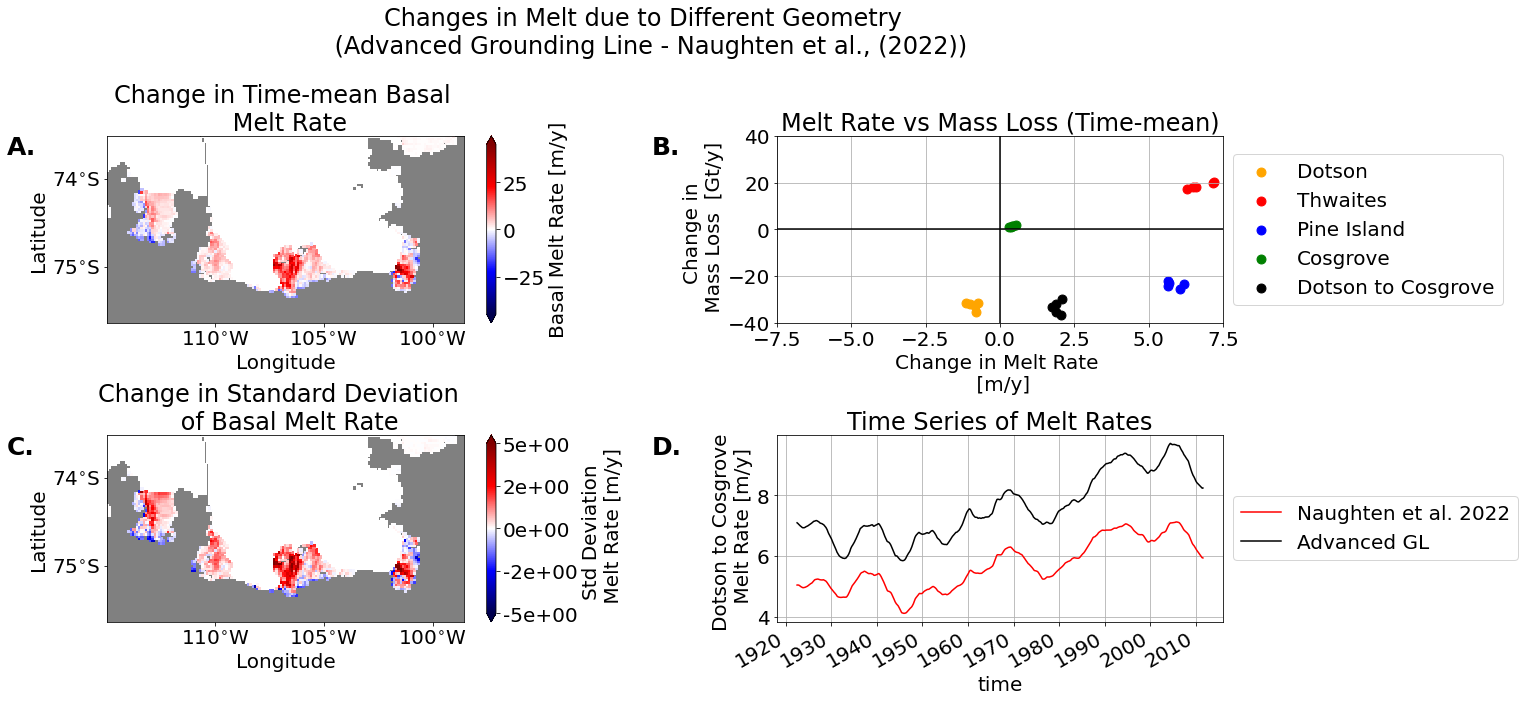

In [12]:
window=60
plt.rcParams.update({'font.size': 20})
fig=plt.figure(figsize=(20,10))

maxlat=np.where(grid.lat_1d>-73.5)[0][0]
minlon=np.where(grid.lon_1d>-115)[0][0]
maxlon=np.where(grid.lon_1d>-98.5)[0][0]

#Compare mean melt
ax=plt.subplot(2,2,1)
plt.pcolor(grid.lon_2d[:maxlat,minlon:maxlon], grid.lat_2d[:maxlat,minlon:maxlon], 
           np.where(grid.get_open_ocean_mask()[:maxlat,minlon:maxlon], np.zeros((maxlat, maxlon-minlon)), np.zeros((maxlat, maxlon-minlon))*np.nan),
           cmap='Greys')
plt.pcolor(GEOSHI['SHIfwFlx'].XC-360, GEOSHI['SHIfwFlx'].YC, GEOSHI['SHIfwFlx'].mean(dim=['time', 'ens'])\
           -SHI['SHIfwFlx'].mean(dim=['time', 'ens']), vmin=-45, vmax=45,
           cmap='seismic')
plt.colorbar(label='Basal Melt Rate [m/y]', extend='both')
ax.set_facecolor('grey')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Change in Time-mean Basal \n Melt Rate')


#Create time mean values
GEOmean=GEO.sel(time=slice('1920', '2013')).mean(dim='time')
PACEmeltmean=PACEmelt.sel(time=slice('1920', '2013')).mean(dim='time')
fullmean=full.sel(time=slice('1920', '2013')).mean(dim='time')

#Compare melt vs mass loss
plt.subplot(2,2,2)
c=['orange', 'red', 'blue', 'green', 'black']
glaciername=['Dotson', 'Thwaites',  'Pine Island', 'Cosgrove', 'Dotson to Cosgrove']
for i, glacier in enumerate(['dotson', 'thwaites',  'pig', 'cosgrove', 'dotson_to_cosgrove']):
    plt.scatter(GEOmean[glacier+'_melting']-PACEmeltmean[glacier+'_melting'],
               GEOmean[glacier+'_massloss']-fullmean[glacier+'_massloss'], c=c[i],
               label=glaciername[i], s=80)
plt.grid()
lgd=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Change in \n Mass Loss  [Gt/y]')
plt.xlabel('Change in Melt Rate \n [m/y]')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim([-7.5, 7.5])
plt.ylim([-40, 40])
plt.title('Melt Rate vs Mass Loss (Time-mean)')


#Compare standard deviation of melt
ax=plt.subplot(2,2,3)
plt.pcolor(grid.lon_2d[:maxlat,minlon:maxlon], grid.lat_2d[:maxlat,minlon:maxlon], 
           np.where(grid.get_open_ocean_mask()[:maxlat,minlon:maxlon], np.zeros((maxlat, maxlon-minlon)), np.zeros((maxlat, maxlon-minlon))*np.nan),
           cmap='Greys')
plt.pcolor(GEOSHI['SHIfwFlx'].XC-360, GEOSHI['SHIfwFlx'].YC, 
           GEOSHI_dt.rolling(time=60, center=True).mean().isel(time=slice(60,-60)).std(dim='time').mean(dim='ens')\
           -SHI_dt.rolling(time=60, center=True).mean().isel(time=slice(60,-60)).std(dim='time').mean(dim='ens'),
           cmap='seismic', vmin=-5, vmax=5)
plt.colorbar(label='Std Deviation \n Melt Rate [m/y]', format='%.0e', extend='both')
ax.set_facecolor('grey')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Change in Standard Deviation  \n of Basal Melt Rate')

#Compare evolution of mel tthrough time
plt.subplot(2,2,4)
PACEmelt['dotson_to_cosgrove_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO['dotson_to_cosgrove_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='Advanced GL')
plt.ylabel('Dotson to Cosgrove \n Melt Rate [m/y]')
plt.grid(True)
plt.title('Time Series of Melt Rates')
lgd=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Changes in Melt due to Different Geometry \n (Advanced Grounding Line - Naughten et al., (2022))')

plt.subplots_adjust(hspace=0.6, wspace=0.5, top=0.8)


import string
for n, ax in enumerate([fig.axes[i] for i in [0,2,3,5]]):
    ax.text(-0.28, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')

for ax in [fig.axes[i] for i in [0, 3]]:
    latlon_axes(ax=ax, x=grid.lon_2d[:maxlat,minlon:maxlon], y=grid.lat_2d[:maxlat,minlon:maxlon])


plt.savefig('../03_output/other/delta_melt_geometry.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

### Visualise differences in ocean mean state

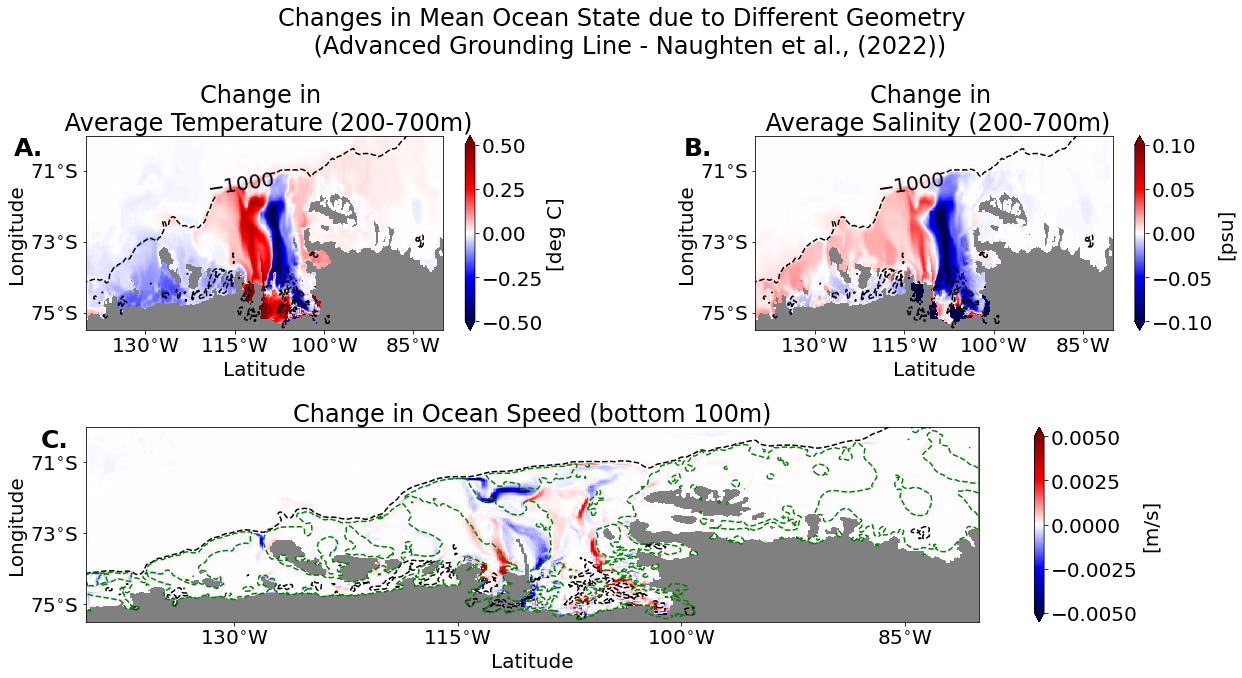

In [13]:
#Visualise maps
window=60
plt.rcParams.update({'font.size': 20})
fig=plt.figure(figsize=(20,10))

maxlat=np.where(grid.lat_1d>-70)[0][0]
minlat=np.where(grid.lat_1d>-75.5)[0][0]

#Difference in Temperature
ax=plt.subplot(2,2,1)
bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
plt.clabel(bath, [-1000])
plt.pcolor(GEOTHETA['THETA'].sel(YC=slice(-75.5, -70)).XC-360, GEOTHETA['THETA'].sel(YC=slice(-75.5, -70)).YC, \
           GEOTHETA['THETA'].sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens'])\
           -THETA['THETA'].sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens']),
           cmap='seismic',vmax=0.5, vmin=-0.5)
plt.colorbar(label='[deg C]', extend='both')
ax.set_facecolor('grey')
ax.set_ylim([-75.5, -70])
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title('Change in \n Average Temperature (200-700m)')

#Difference in Salinity
ax=plt.subplot(2,2,2)
bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
plt.clabel(bath, [-1000])
plt.pcolor(GEOSALT['SALT'].sel(YC=slice(-75.5, -70)).XC-360, GEOSALT['SALT'].sel(YC=slice(-75.5, -70)).YC, \
           GEOSALT['SALT'].sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens'])\
           -SALT['SALT'].sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens']),
           cmap='seismic',vmax=0.1, vmin=-0.1)
plt.colorbar(label='[psu]', extend='both')
ax.set_facecolor('grey')
ax.set_ylim([-75.5, -70])
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title('Change in \n Average Salinity (200-700m)')

#Difference in velocity
ax=plt.subplot(2,1,2)
bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000, -500], colors=['black', 'green'],\
               linestyles='dashed')
plt.pcolor(GEOVEL.sel(YC=slice(-75.5, -70)).XC-360, GEOVEL.sel(YC=slice(-75.5, -70)).YC, \
           GEOVEL.sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens'])\
           -VEL.sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens']),
           cmap='seismic',vmax=0.005, vmin=-0.005)
plt.colorbar(label='[m/s]', extend='both')
ax.set_facecolor('grey')
ax.set_ylim([-75.5, -70])
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title('Change in Ocean Speed (bottom 100m)')

plt.suptitle('Changes in Mean Ocean State due to Different Geometry \n (Advanced Grounding Line - Naughten et al., (2022))')
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.8)

import string
for n, ax in enumerate(fig.axes[::2]):
    if n==2:
        ax.text(-0.05, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
                size=25, weight='bold')
    else:
        ax.text(-0.2, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
                size=25, weight='bold')
    ax.set_xticks([-130, -115, -100, -85])
    ax.set_yticks([-75, -73, -71])
    latlon_axes(ax=ax, x=grid.lon_1d, y=grid.lat_1d[minlat:maxlat])

plt.savefig('../03_output/other/new_geometry_ocean.png')

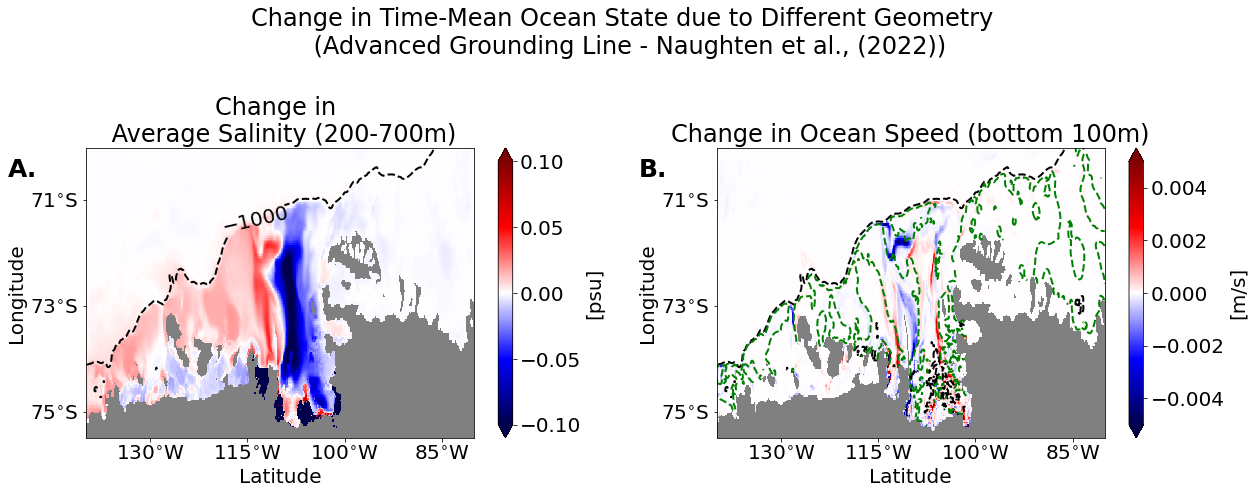

In [21]:
#Visualise maps
window=60
plt.rcParams.update({'font.size': 20})
fig=plt.figure(figsize=(20,7))

maxlat=np.where(grid.lat_1d>-70)[0][0]
minlat=np.where(grid.lat_1d>-75.5)[0][0]

# #Difference in Temperature
# ax=plt.subplot(1,2,1)
# bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
# plt.clabel(bath, [-1000])
# plt.pcolor(GEOTHETA['THETA'].sel(YC=slice(-75.5, -70)).XC-360, GEOTHETA['THETA'].sel(YC=slice(-75.5, -70)).YC, \
#            GEOTHETA['THETA'].sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens'])\
#            -THETA['THETA'].sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens']),
#            cmap='seismic',vmax=0.5, vmin=-0.5)
# plt.colorbar(label='[deg C]', extend='both')
# ax.set_facecolor('grey')
# ax.set_ylim([-75.5, -70])
# plt.ylabel('Longitude')
# plt.xlabel('Latitude')
# plt.title('Change in \n Average Temperature (200-700m)')

#Difference in Salinity
ax=plt.subplot(1,2,1)
grid = Grid(gp)
bathy=grid.bathy
bathy[grid.ice_mask | ((grid.lon_2d>-119) & (grid.lat_2d<-72.5))]=np.nan
bath=plt.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], linewidths=[2], colors=['black'])
plt.clabel(bath, [-1000])
# bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
# plt.clabel(bath, [-1000])
plt.pcolor(GEOSALT['SALT'].sel(YC=slice(-75.5, -70)).XC-360, GEOSALT['SALT'].sel(YC=slice(-75.5, -70)).YC, \
           GEOSALT['SALT'].sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens'])\
           -SALT['SALT'].sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens']),
           cmap='seismic',vmax=0.1, vmin=-0.1)
plt.colorbar(label='[psu]', extend='both')
ax.set_facecolor('grey')
ax.set_ylim([-75.5, -70])
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title('Change in \n Average Salinity (200-700m)')

#Difference in velocity
ax=plt.subplot(1,2,2)
grid = Grid(gp)
bathy=grid.bathy
bathy[grid.ice_mask]=np.nan
bath=plt.contour(grid.lon_2d, grid.lat_2d, bathy, levels=[-1000,-500], linewidths=[2], colors=['black','green'], linestyles='dashed')
#plt.clabel(bath, [-1000, -500])

#bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000, -500], colors=['black', ],\
#               linestyles='dashed')
plt.pcolor(GEOVEL.sel(YC=slice(-75.5, -70)).XC-360, GEOVEL.sel(YC=slice(-75.5, -70)).YC, \
           GEOVEL.sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens'])\
           -VEL.sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens']),
           cmap='seismic',vmax=0.005, vmin=-0.005)
plt.colorbar(label='[m/s]', extend='both')
ax.set_facecolor('grey')
ax.set_ylim([-75.5, -70])
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title('Change in Ocean Speed (bottom 100m)')

plt.suptitle('Change in Time-Mean Ocean State due to Different Geometry \n (Advanced Grounding Line - Naughten et al., (2022))')
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.7)

import string
for n, ax in enumerate(fig.axes[::2]):
    if n==2:
        ax.text(-0.05, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
                size=25, weight='bold')
    else:
        ax.text(-0.2, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
                size=25, weight='bold')
    ax.set_xticks([-130, -115, -100, -85])
    ax.set_yticks([-75, -73, -71])
    latlon_axes(ax=ax, x=grid.lon_1d, y=grid.lat_1d[minlat:maxlat])

#plt.savefig('../03_output/other/new_geometry_ocean.png')

### Show ocean mean state in slices

/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(h_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(z_labels)


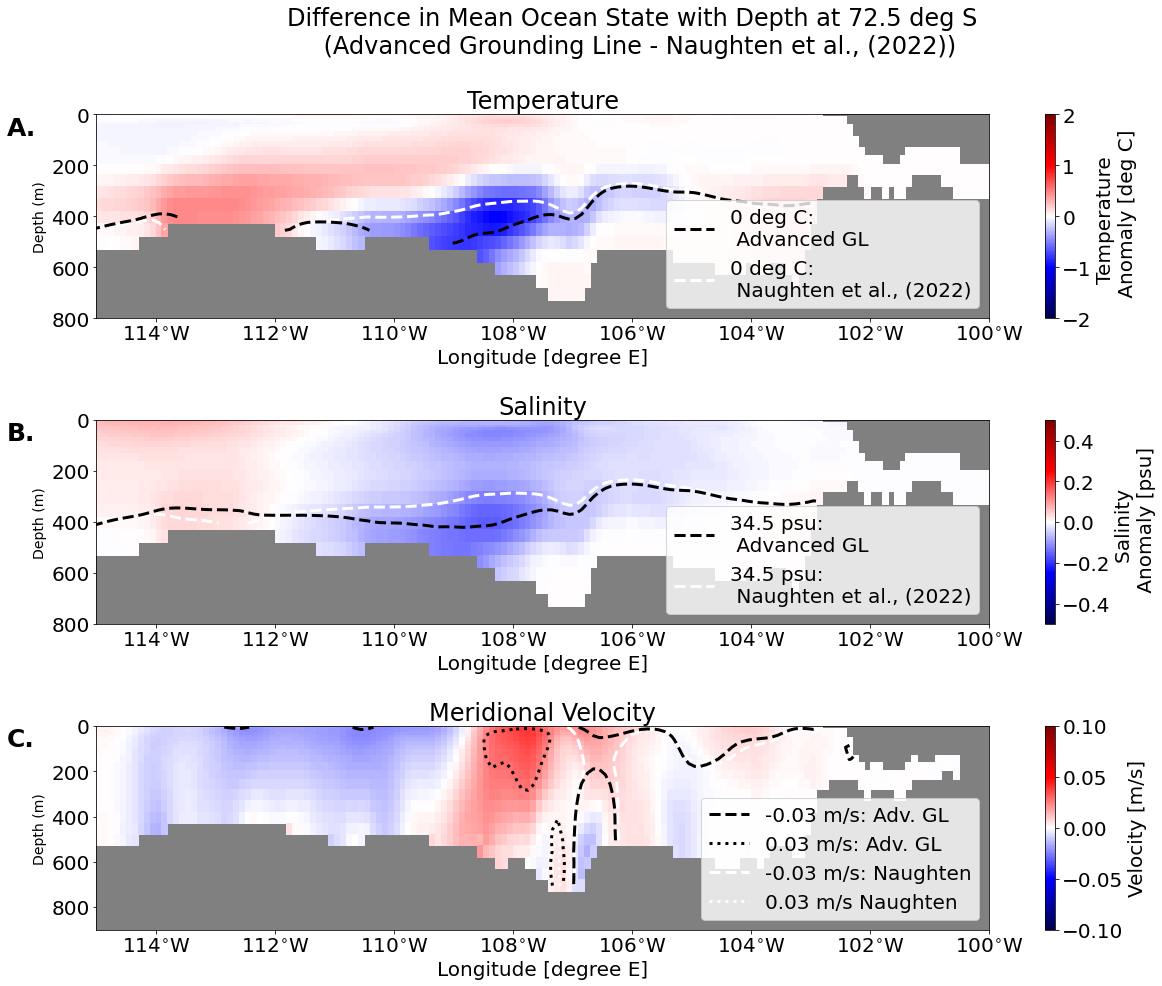

In [55]:
fig=plt.figure(figsize=(20,15))
ax=plt.subplot(3,1,1)
ax.set_title('Temperature')
img=ax.pcolor(dataT.XC-360, dataT.Z, GEOTmean-dataTmean, \
              cmap='seismic', vmin=-2, vmax=2)

CS1=ax.contour(dataT.XC-360, dataT.Z, dataTmean, \
           levels=[0], colors=['white'],\
           linestyles='dashed', linewidths=3)
CS2=ax.contour(dataT.XC-360, dataT.Z, GEOTmean, \
           levels=[0], colors=['black'],\
           linestyles='dashed', linewidths=3)


plt.colorbar(img, label='Temperature \n Anomaly [deg C]')
ax.set_xlim([245-360, 260-360])
ax.set_ylim([-800, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Longitude [degree E]')
ax.set_facecolor('grey')

h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
ax.legend([h2[0], h1[0]], ['0 deg C: \n Advanced GL', '0 deg C: \n Naughten et al., (2022)'], loc='lower right')


ax=plt.subplot(3,1,2)
ax.set_title('Salinity')
img=ax.pcolor(dataS.XC-360, dataS.Z, GEOSmean-dataSmean, \
              cmap='seismic', vmin=-0.5, vmax=0.5)

CS1=ax.contour(dataS.XC-360, dataS.Z, dataSmean, \
           levels=[34.5], colors=['white'],\
           linestyles='dashed', linewidths=3)
CS2=ax.contour(dataS.XC-360, dataS.Z, GEOSmean, \
           levels=[34.5], colors=['black'],\
           linestyles='dashed', linewidths=3)

plt.colorbar(img, label='Salinity \n Anomaly [psu]')
ax.set_xlim([245-360, 260-360])
ax.set_ylim([-800, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Longitude [degree E]')
ax.set_facecolor('grey')
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
ax.legend([h2[0], h1[0]], ['34.5 psu: \n Advanced GL', '34.5 psu: \n Naughten et al., (2022)'], loc='lower right')


ax=plt.subplot(3,1,3)
ax.set_title('Meridional Velocity')
img=ax.pcolor(dataV.XC-360, dataV.Z, GEOVmean-dataVmean, \
              cmap='seismic', vmin=-0.1, vmax=0.1)

CS1=ax.contour(dataV.XC-360, dataV.Z, dataVmean, \
           levels=[-0.03, 0.03], colors=['white'],\
           linestyles=['dashed','dotted'], linewidths=3)
CS2=ax.contour(dataV.XC-360, dataV.Z, GEOVmean, \
           levels=[-0.03, 0.03], colors=['black'],\
           linestyles=['dashed', 'dotted'], linewidths=3)

plt.colorbar(img, label='Velocity [m/s]')
ax.set_xlim([245-360, 260-360])
ax.set_ylim([-900, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Longitude [degree E]')
ax.set_facecolor('grey')
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
ax.legend([h2[0],h2[1], h1[0], h1[1]], ['-0.03 m/s: Adv. GL', '0.03 m/s: Adv. GL', \
                                        '-0.03 m/s: Naughten', '0.03 m/s Naughten'], \
          loc='lower right', ncol=1)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Difference in Mean Ocean State with Depth at 72.5 deg S \n (Advanced Grounding Line - Naughten et al., (2022))')

for n, ax in enumerate(fig.axes[::2]):
    ax.text(-0.1, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
                size=25, weight='bold')
    #ax.set_xticks([-130, -115, -100, -85])
    slice_axes(ax=ax, h_axis='lon')



plt.savefig('../03_output/slices/newgeometry_differences_S72-5.png')


In [57]:
# #BONUS Illustrate velocity changes separately
# plt.figure(figsize=(20,15))
# ax=plt.subplot(2,1,1)
# ax.set_title('Meridional Velocity')
# img=ax.pcolor(dataV.XC, dataV.Z, dataVmean, \
#               cmap='seismic', vmin=-0.1, vmax=0.1)

# CS1=ax.contour(dataV.XC, dataV.Z, dataVmean, \
#            levels=[-0.05, 0.05], colors=['white'],\
#            linestyles='dashed', linewidths=3)
# CS2=ax.contour(dataV.XC, dataV.Z, GEOVmean, \
#            levels=[-0.05, 0.05], colors=['black'],\
#            linestyles='dashed', linewidths=3)

# plt.colorbar(img, label='Velocity [m/s]')
# ax.set_xlim([240, 260])
# ax.set_ylim([-800, 0])
# ax.set_ylabel('Depth [m]')
# ax.set_xlabel('Longitude [degree E]')
# ax.set_facecolor('grey')
# h1,_ = CS1.legend_elements()
# h2,_ = CS2.legend_elements()
# ax.legend([h1[0], h2[0]], ['(+ or -) 0.05 m/s: Naughten et al., (2022)', '(+ or -) 0.05 m/s: New Geometry'], loc='lower left')


# ax=plt.subplot(2,1,2)
# ax.set_title('Meridional Velocity')
# img=ax.pcolor(dataV.XC, dataV.Z, GEOVmean, \
#               cmap='seismic', vmin=-0.1, vmax=0.1)

# CS1=ax.contour(dataV.XC, dataV.Z, dataVmean, \
#            levels=[-0.05, 0.05], colors=['white'],\
#            linestyles='dashed', linewidths=3)
# CS2=ax.contour(dataV.XC, dataV.Z, GEOVmean, \
#            levels=[-0.05, 0.05], colors=['black'],\
#            linestyles='dashed', linewidths=3)

# plt.colorbar(img, label='Velocity [m/s]')
# ax.set_xlim([240, 260])
# ax.set_ylim([-800, 0])
# ax.set_ylabel('Depth [m]')
# ax.set_xlabel('Longitude [degree E]')
# ax.set_facecolor('grey')
# h1,_ = CS1.legend_elements()
# h2,_ = CS2.legend_elements()
# ax.legend([h1[0], h2[0]], ['(+ or -) 0.05 m/s: Naughten et al., (2022)', '(+ or -) 0.05 m/s: New Geometry'], loc='lower left')


In [5]:
#Show differences in mean values
# print('Difference in mean sea ice freshwater flux:')
# print(GEOSI.sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values\
#       -SI.sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values)

ML_new=GEO['all_massloss'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
ML_old=full['all_massloss'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
ML_old_std=full['all_massloss'].sel(time=slice('1920', '2013')).rolling(time=60,center=True).mean().std(dim='time').mean(dim=['ens']).values

SL_new=GEO['amundsen_shelf_salt_below_0m'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
SL_old=salt['amundsen_shelf_salt_below_0m'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
SL_old_std=salt['amundsen_shelf_salt_below_0m'].sel(time=slice('1920', '2013')).rolling(time=60,center=True).mean().std(dim='time').mean(dim=['ens']).values


OHC_new=GEO['amundsen_shelf_ohc_below_0m'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
OHC_old=OHC['amundsen_shelf_ohc_below_0m'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
OHC_old_std=OHC['amundsen_shelf_ohc_below_0m'].sel(time=slice('1920', '2013')).rolling(time=60,center=True).mean().std(dim='time').mean(dim=['ens']).values


T_new=GEO['amundsen_shelf_temp_btw_200_700m'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
T_old=full['amundsen_shelf_temp_btw_200_700m'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
T_old_std=full['amundsen_shelf_temp_btw_200_700m'].sel(time=slice('1920', '2013')).rolling(time=60,center=True).mean().std(dim='time').mean(dim=['ens']).values



print('Difference in all mass loss rate:')
print('Absolute: '+str(ML_new-ML_old))
print('Percentage: '+str(100*(ML_new-ML_old)/ML_old)+' pct')
print('Std Changes: '+str((ML_new-ML_old)/ML_old_std)+' Stds')


print('Difference in mean salinity:')
print('Absolute: '+str(SL_new-SL_old))
print('Percentage: '+str(100*(SL_new-SL_old)/SL_old)+' pct')
print('Std Changes: '+str((SL_new-SL_old)/SL_old_std)+' Stds')

print('Difference in OHC:')
print('Absolute: '+str(OHC_new-OHC_old))
print('Percentage: '+str(100*(OHC_new-OHC_old)/OHC_old)+' pct')
print('Std Changes: '+str((OHC_new-OHC_old)/OHC_old_std)+' Stds')

print('Difference in temperature (200-700m):')
print('Absolute: '+str(T_new-T_old))
print('Percentage: '+str(100*(T_new-T_old)/T_old)+' pct')
print('Std Changes: '+str((T_new-T_old)/T_old_std)+' Stds')

Difference in all mass loss rate:
Absolute: -42.693247884340224
Percentage: -11.962531514770784 pct
Std Changes: -0.49083547957859175 Stds
Difference in mean salinity:
Absolute: -0.015473921991564055
Percentage: -0.044942020994346764 pct
Std Changes: -1.2515156956331173 Stds
Difference in OHC:
Absolute: 15376436163.625
Percentage: 0.012944749709142606 pct
Std Changes: 0.31150816573353124 Stds
Difference in temperature (200-700m):
Absolute: -0.00736061101444592
Percentage: 6.730146344624377 pct
Std Changes: -0.047560265044463625 Stds


In [13]:
DML_new=GEO['thwaites_massloss'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
DML_old=full['thwaites_massloss'].sel(time=slice('1920', '2013')).mean(dim=['ens', 'time']).values
#DML_old_std=full['dotson_to_cosgrove_melting'].sel(time=slice('1920', '2013')).rolling(time=60,center=True).mean().std(dim='time').mean(dim=['ens']).values
print(DML_old)
print(DML_new)
print(DML_new-DML_old)

15.240115597166092
33.892621916087236
18.652506318921144


## Decadal variability with the New Geometry

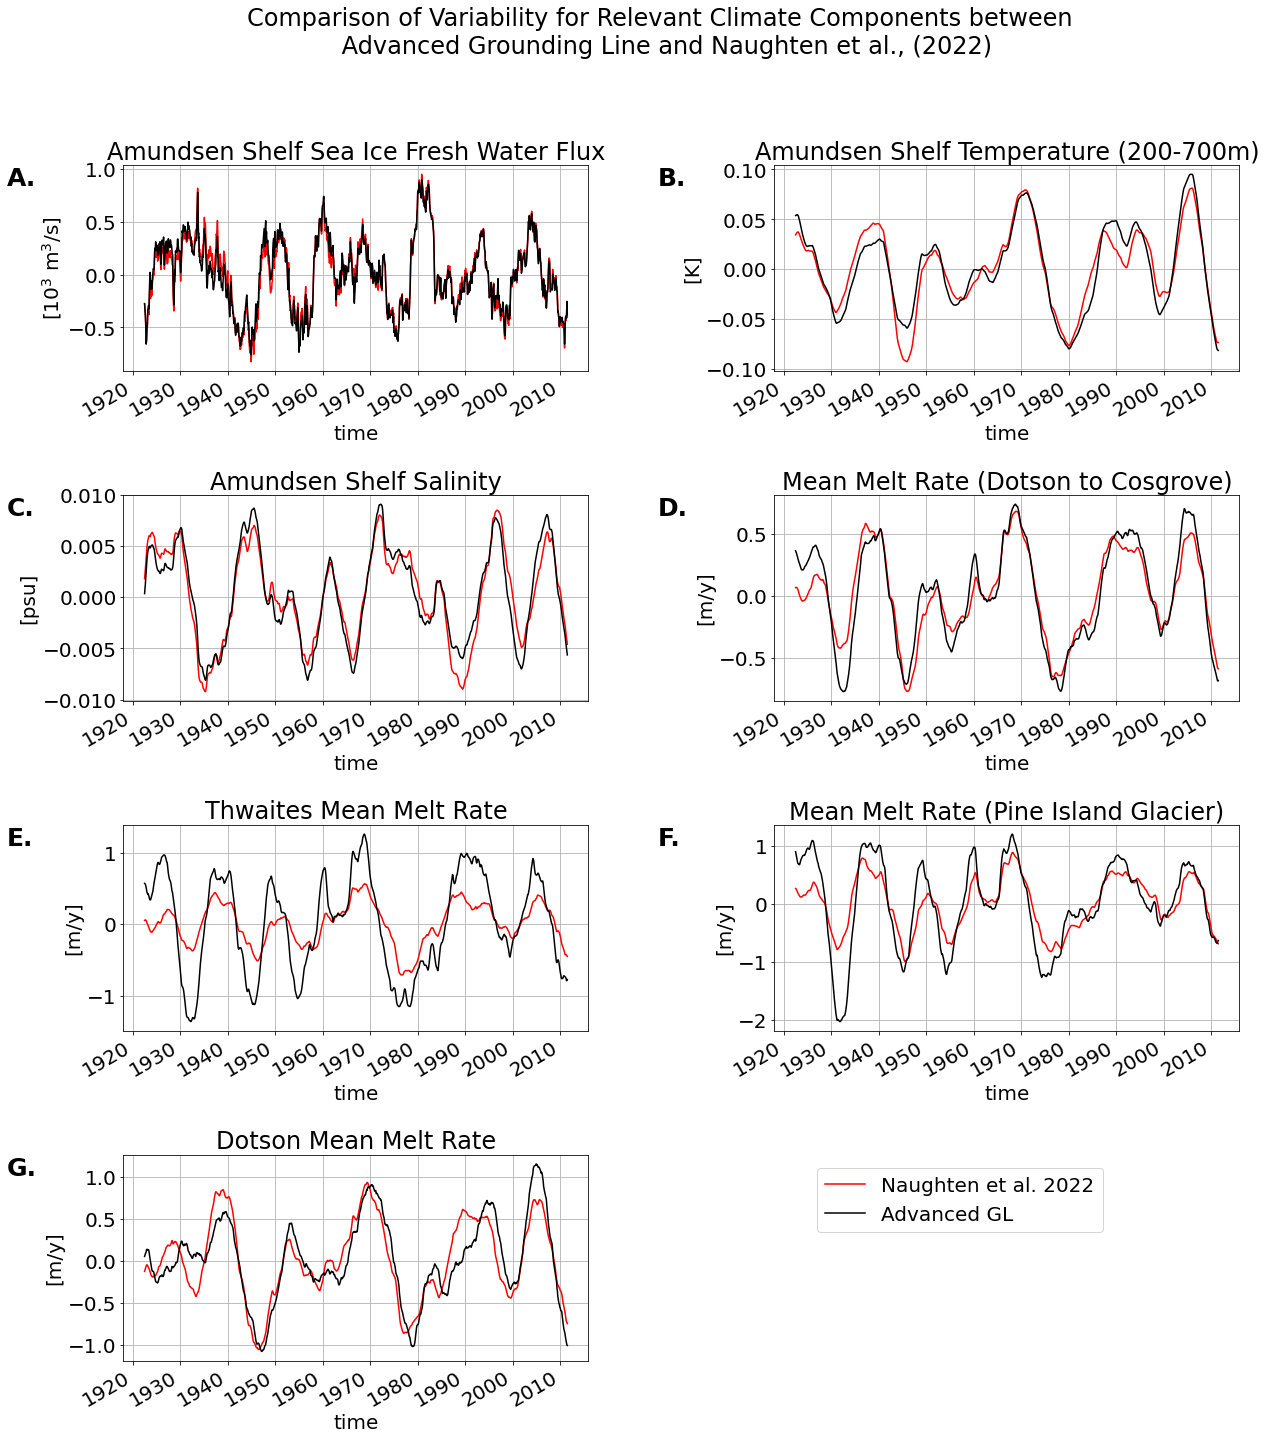

In [24]:
#Compare Mean Melt
fig=plt.figure(figsize=(20,22))
window=60

# plt.subplot(4,2,1)
# full_dt['amundsen_shelf_break_uwind_avg'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['amundsen_shelf_break_uwind_avg'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# plt.legend()
# plt.grid(True)
# plt.ylabel('[m/s]')
# plt.title('Amundsen Shelf Break Zonal Wind')

plt.subplot(4,2,1)
SI_dt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEOSI_dt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='Advanced GL')
#plt.legend(loc='lower right')
plt.grid(True)
plt.ylabel('[10$^3$ m$^3$/s]')
plt.title('Amundsen Shelf Sea Ice Fresh Water Flux')

plt.subplot(4,2,2)
full_dt['amundsen_shelf_temp_btw_200_700m'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='')
GEO_dt['amundsen_shelf_temp_btw_200_700m'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='')
#plt.legend()
plt.grid(True)
plt.ylabel('[K]')
plt.title('Amundsen Shelf Temperature (200-700m)')

plt.subplot(4,2,3)
salt_dt['amundsen_shelf_salt_below_0m'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='')
GEO_dt['amundsen_shelf_salt_below_0m'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='')
#plt.legend()
plt.grid(True)
plt.ylabel('[psu]')
plt.title('Amundsen Shelf Salinity')


plt.subplot(4,2,4)
PACEmelt_dt['dotson_to_cosgrove_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='')
GEO_dt['dotson_to_cosgrove_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Mean Melt Rate (Dotson to Cosgrove)')

plt.subplot(4,2,5)
PACEmelt_dt['thwaites_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='')
GEO_dt['thwaites_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Thwaites Mean Melt Rate')

plt.subplot(4,2,6)
PACEmelt_dt['pig_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='')
GEO_dt['pig_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Mean Melt Rate (Pine Island Glacier)')

plt.subplot(4,2,7)
PACEmelt_dt['dotson_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='')
GEO_dt['dotson_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Dotson Mean Melt Rate')

#Separate plots for mass loss
# plt.subplot(4,2,5)
# full_dt['dotson_to_cosgrove_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['dotson_to_cosgrove_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# #plt.legend()
# plt.grid(True)
# plt.ylabel('[Gt/y]')
# plt.title('Dotson to Cosgrove Mass Loss')


# plt.subplot(4,2,6)
# full_dt['thwaites_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['thwaites_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# #plt.legend()
# plt.grid(True)
# plt.ylabel('[Gt/y]')
# plt.title('Thwaites Mass Loss')


# plt.subplot(4,2,7)
# full_dt['pig_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['pig_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# #plt.legend()
# plt.grid(True)
# plt.ylabel('[Gt/y]')
# plt.title('Pine Island Glacier Mass Loss')


# plt.subplot(4,2,8)
# full_dt['dotson_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['dotson_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# #plt.legend()
# plt.grid(True)
# plt.ylabel('[Gt/y]')
# plt.title('Dotson Mass Loss')


plt.suptitle('Comparison of Variability for Relevant Climate Components between \n Advanced Grounding Line and Naughten et al., (2022)')
plt.subplots_adjust(hspace=0.6, wspace=0.4)

import string
for n, ax in enumerate(fig.axes):
        ax.text(-0.25, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')
fig.legend(bbox_to_anchor=(0.6, 0.2, 0.2, .6), loc='lower left')

# plt.savefig('../03_output/timeseries/new_geometry_decadal_variability_massloss.png')

plt.savefig('../03_output/timeseries/new_geometry_decadal_variability_melting.png')

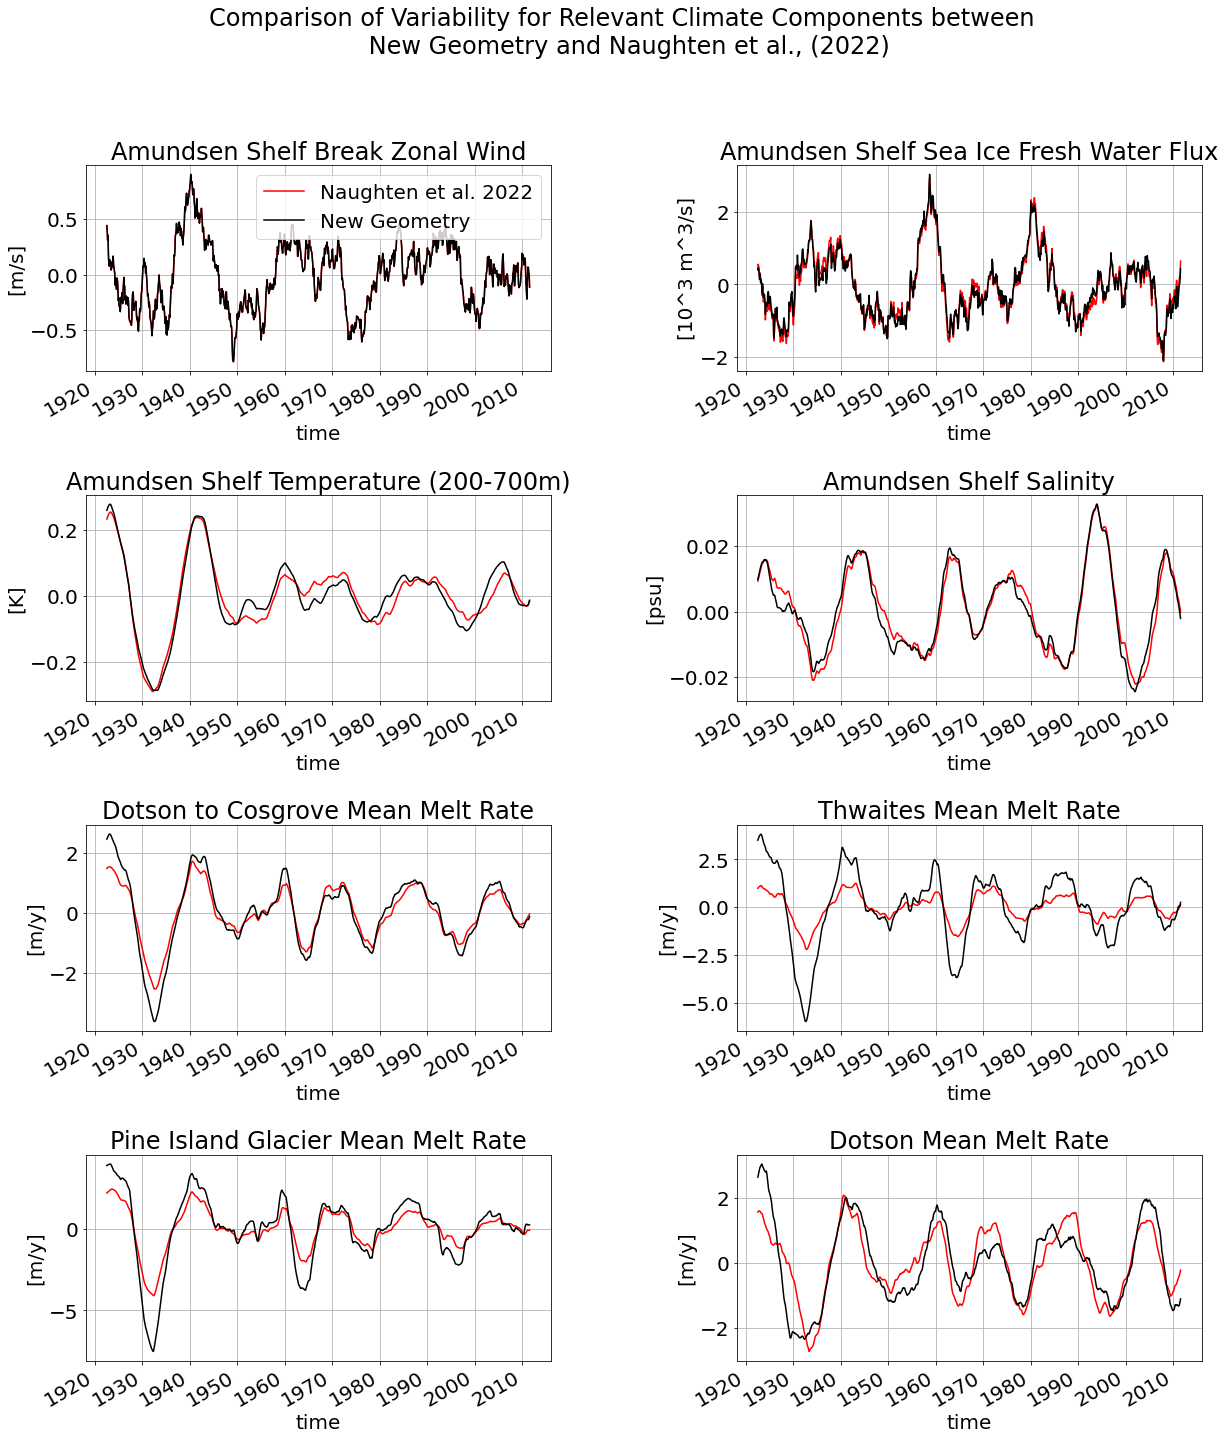

In [30]:
#Same for individual members

ens1=1

plt.figure(figsize=(20,22))
window=60

plt.subplot(4,2,1)
full_dt['amundsen_shelf_break_uwind_avg'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['amundsen_shelf_break_uwind_avg'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
plt.legend()
plt.grid(True)
plt.ylabel('[m/s]')
plt.title('Amundsen Shelf Break Zonal Wind')

plt.subplot(4,2,2)
SI_dt.sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEOSI_dt.sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[10^3 m^3/s]')
plt.title('Amundsen Shelf Sea Ice Fresh Water Flux')

plt.subplot(4,2,3)
full_dt['amundsen_shelf_temp_btw_200_700m'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['amundsen_shelf_temp_btw_200_700m'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[K]')
plt.title('Amundsen Shelf Temperature (200-700m)')

plt.subplot(4,2,4)
salt_dt['amundsen_shelf_salt_below_0m'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['amundsen_shelf_salt_below_0m'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[psu]')
plt.title('Amundsen Shelf Salinity')


plt.subplot(4,2,5)
PACEmelt_dt['dotson_to_cosgrove_melting'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['dotson_to_cosgrove_melting'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Dotson to Cosgrove Mean Melt Rate')

plt.subplot(4,2,6)
PACEmelt_dt['thwaites_melting'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['thwaites_melting'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Thwaites Mean Melt Rate')

plt.subplot(4,2,7)
PACEmelt_dt['pig_melting'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['pig_melting'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Pine Island Glacier Mean Melt Rate')

plt.subplot(4,2,8)
PACEmelt_dt['dotson_melting'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['dotson_melting'].sel(ens=ens1).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Dotson Mean Melt Rate')

# plt.subplot(4,2,5)
# full_dt['dotson_to_cosgrove_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['dotson_to_cosgrove_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# #plt.legend()
# plt.grid(True)
# plt.ylabel('[Gt/y]')
# plt.title('Dotson to Cosgrove Mass Loss')


# plt.subplot(4,2,6)
# full_dt['thwaites_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['thwaites_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# #plt.legend()
# plt.grid(True)
# plt.ylabel('[Gt/y]')
# plt.title('Thwaites Mass Loss')


# plt.subplot(4,2,7)
# full_dt['pig_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['pig_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# #plt.legend()
# plt.grid(True)
# plt.ylabel('[Gt/y]')
# plt.title('Pine Island Glacier Mass Loss')


# plt.subplot(4,2,8)
# full_dt['dotson_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
# GEO_dt['dotson_massloss'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
# #plt.legend()
# plt.grid(True)
# plt.ylabel('[Gt/y]')
# plt.title('Dotson Mass Loss')


plt.suptitle('Comparison of Variability for Relevant Climate Components between \n New Geometry and Naughten et al., (2022)')
plt.subplots_adjust(hspace=0.6, wspace=0.4)

## 1940s: what happened to melt anomaly?

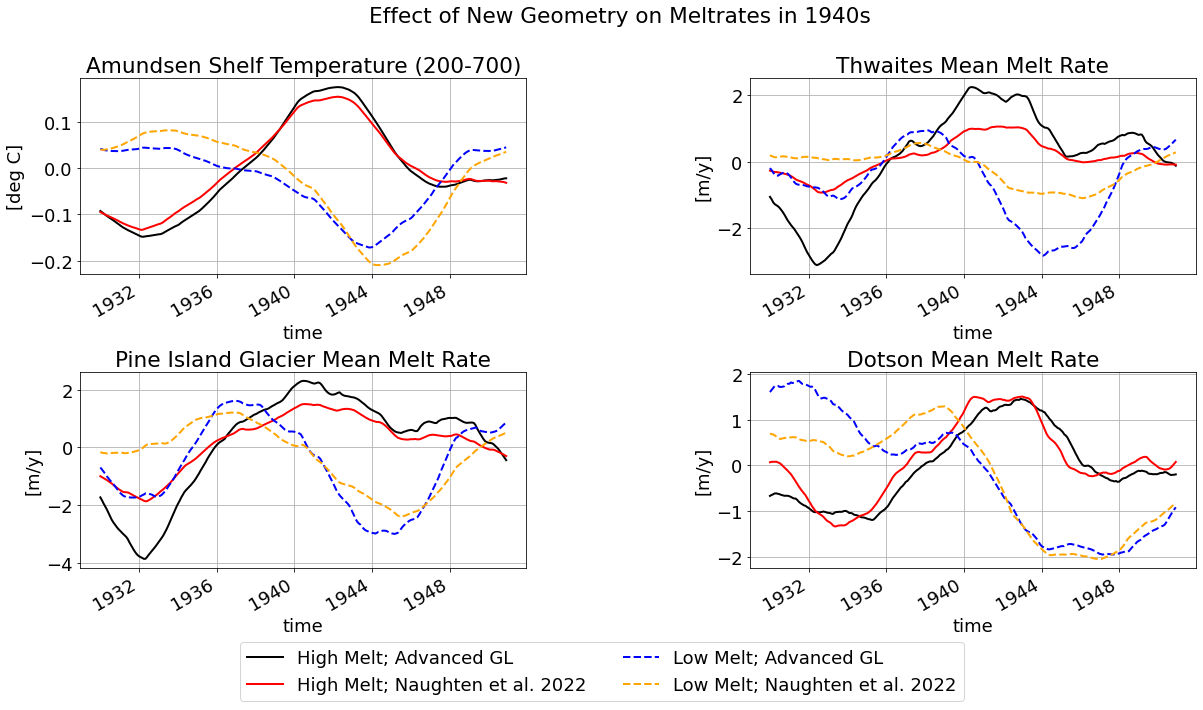

In [7]:
#Function to show high and low melt members

def plot_1940s_newgeometry(ax, GEO, full, window=60, legend=False):
    if legend==True:
        #High Melt 
        GEO.sel(ens=[1, 2]).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean()\
        .sel(time=slice('1930', '1950')).mean(dim='ens')\
        .plot(c='k', ls='-',  lw=2, label='High Melt; Advanced GL')

        full.sel(ens=[1,2]).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean()\
        .sel(time=slice('1930', '1950')).mean(dim='ens')\
        .plot(c='r', ls='-', lw=2, label='High Melt; Naughten et al. 2022')

        #Low Melt 
        GEO.sel(ens=[3, 4]).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean()\
        .sel(time=slice('1930', '1950')).mean(dim='ens')\
        .plot(c='b', ls='--',  lw=2, label='Low Melt; Advanced GL')

        full.sel(ens=[3, 4]).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean()\
        .sel(time=slice('1930', '1950')).mean(dim='ens')\
        .plot(c='orange', ls='--', lw=2, label='Low Melt; Naughten et al. 2022')
        plt.grid()
    else:
        #High Melt 
        GEO.sel(ens=[1, 2]).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean()\
        .sel(time=slice('1930', '1950')).mean(dim='ens')\
        .plot(c='k', ls='-',  lw=2)

        full.sel(ens=[1,2]).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean()\
        .sel(time=slice('1930', '1950')).mean(dim='ens')\
        .plot(c='r', ls='-', lw=2)

        #Low Melt 
        GEO.sel(ens=[3, 4]).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean()\
        .sel(time=slice('1930', '1950')).mean(dim='ens')\
        .plot(c='b', ls='--',  lw=2)

        full.sel(ens=[3, 4]).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean()\
        .sel(time=slice('1930', '1950')).mean(dim='ens')\
        .plot(c='orange', ls='--', lw=2)
        plt.grid()
    
    return ax

fig=plt.figure(figsize=(20,10))
ax=plt.subplot(2,2,1)
plot_1940s_newgeometry(ax=ax, GEO=GEO_dt['amundsen_shelf_temp_btw_200_700m'],\
                       full=full_dt['amundsen_shelf_temp_btw_200_700m'], window=60, legend=True)

plt.ylabel('[deg C]')
plt.title('Amundsen Shelf Temperature (200-700)')

ax=plt.subplot(2,2,2)
plot_1940s_newgeometry(ax=ax, GEO=GEO_dt['thwaites_melting'],\
                       full=PACEmelt_dt['thwaites_melting'], window=60)

plt.ylabel('[m/y]')
#plt.legend()
plt.title('Thwaites Mean Melt Rate')

ax=plt.subplot(2,2,3)
plot_1940s_newgeometry(ax=ax, GEO=GEO_dt['pig_melting'],\
                       full=PACEmelt_dt['pig_melting'], window=60)

plt.ylabel('[m/y]')
#plt.legend()
plt.title('Pine Island Glacier Mean Melt Rate')

ax=plt.subplot(2,2,4)
plot_1940s_newgeometry(ax=ax, GEO=GEO_dt['dotson_melting'],\
                       full=PACEmelt_dt['dotson_melting'], window=60)

plt.ylabel('[m/y]')
#plt.legend()
plt.title('Dotson Mean Melt Rate')

fig.legend(loc='lower center', ncol = 2)
plt.subplots_adjust(hspace=0.5, wspace=0.5, bottom=0.2,)
plt.suptitle('Effect of New Geometry on Meltrates in 1940s')

plt.savefig('../03_output/timeseries/new_geometry_1940s.png')


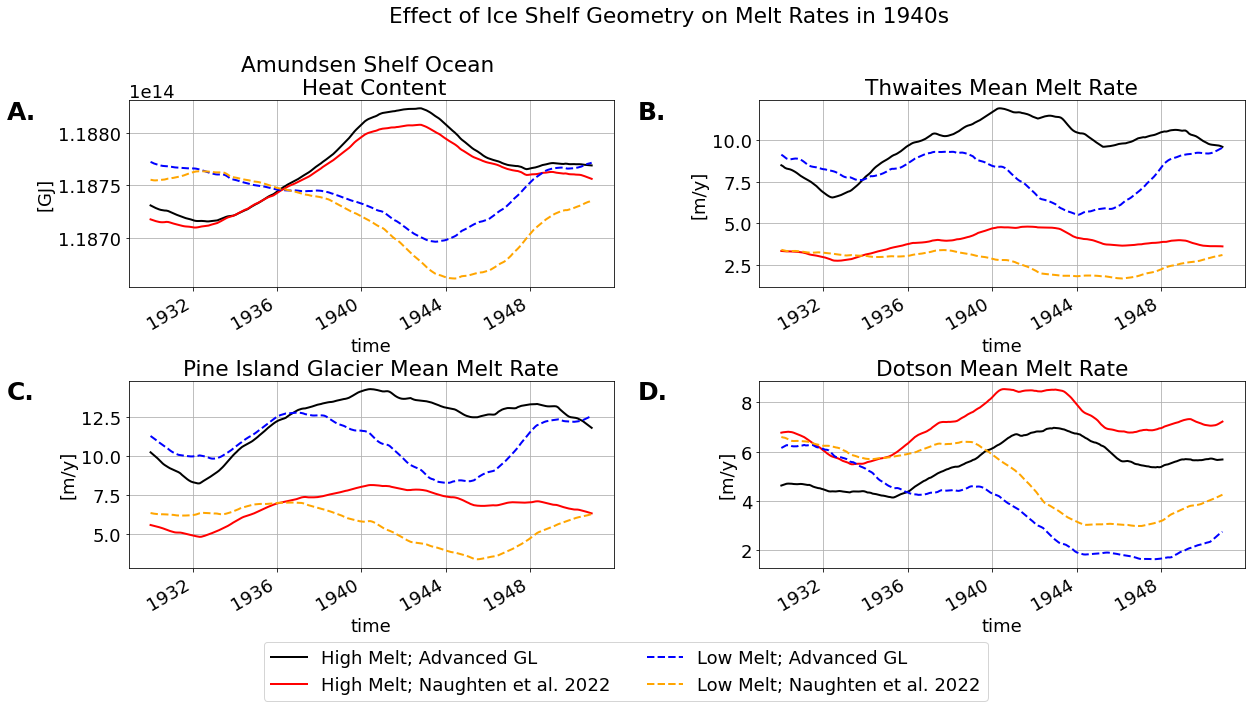

In [9]:

fig=plt.figure(figsize=(20,10))
ax=plt.subplot(2,2,1)
plot_1940s_newgeometry(ax=ax, GEO=GEO['amundsen_shelf_ohc_below_0m'],\
                       full=OHC['amundsen_shelf_ohc_below_0m'], window=60, legend=True)
plt.ylabel('[GJ]')
plt.title('Amundsen Shelf Ocean \n Heat Content')

ax=plt.subplot(2,2,2)
plot_1940s_newgeometry(ax=ax, GEO=GEO['thwaites_melting'],\
                       full=PACEmelt['thwaites_melting'], window=60)

plt.ylabel('[m/y]')
plt.title('Thwaites Mean Melt Rate')

ax=plt.subplot(2,2,3)
plot_1940s_newgeometry(ax=ax, GEO=GEO['pig_melting'],\
                       full=PACEmelt['pig_melting'], window=60)

plt.ylabel('[m/y]')
plt.title('Pine Island Glacier Mean Melt Rate')

ax=plt.subplot(2,2,4)
plot_1940s_newgeometry(ax=ax, GEO=GEO['dotson_melting'],\
                       full=PACEmelt['dotson_melting'], window=60)

plt.ylabel('[m/y]')
plt.title('Dotson Mean Melt Rate')

fig.legend(loc='lower center', ncol = 2)
plt.subplots_adjust(hspace=0.5, wspace=0.3, bottom=0.2, top=0.85)
plt.suptitle('Effect of Ice Shelf Geometry on Melt Rates in 1940s')

import string
for n, ax in enumerate(fig.axes):
        ax.text(-0.25, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')

plt.savefig('../03_output/timeseries/new_geometry_1940s_OHC.png')


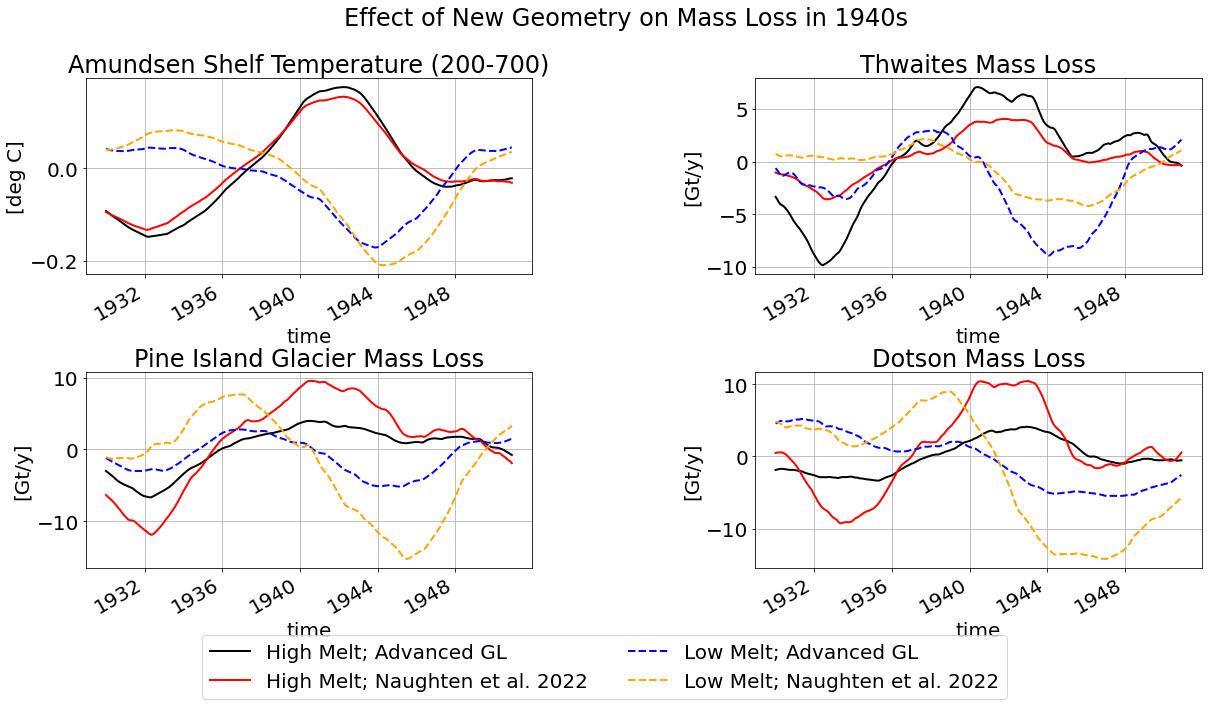

In [84]:
fig=plt.figure(figsize=(20,10))
ax=plt.subplot(2,2,1)
plot_1940s_newgeometry(ax=ax, GEO=GEO_dt['amundsen_shelf_temp_btw_200_700m'],\
                       full=full_dt['amundsen_shelf_temp_btw_200_700m'], window=60, legend=True)

plt.ylabel('[deg C]')
plt.title('Amundsen Shelf Temperature (200-700)')

ax=plt.subplot(2,2,2)
plot_1940s_newgeometry(ax=ax, GEO=GEO_dt['thwaites_massloss'],\
                       full=full_dt['thwaites_massloss'], window=60)

plt.ylabel('[Gt/y]')
#plt.legend()
plt.title('Thwaites Mass Loss')

ax=plt.subplot(2,2,3)
plot_1940s_newgeometry(ax=ax, GEO=GEO_dt['pig_massloss'],\
                       full=full_dt['pig_massloss'], window=60)

plt.ylabel('[Gt/y]')
#plt.legend()
plt.title('Pine Island Glacier Mass Loss')

ax=plt.subplot(2,2,4)
plot_1940s_newgeometry(ax=ax, GEO=GEO_dt['dotson_massloss'],\
                       full=full_dt['dotson_massloss'], window=60)

plt.ylabel('[Gt/y]')
#plt.legend()
plt.title('Dotson Mass Loss')

fig.legend(loc='lower center', ncol = 2)
plt.subplots_adjust(hspace=0.5, wspace=0.5, bottom=0.2,)
plt.suptitle('Effect of New Geometry on Mass Loss in 1940s')

plt.savefig('../03_output/timeseries/new_geometry_1940s_massloss.png')

# BONUS: old code

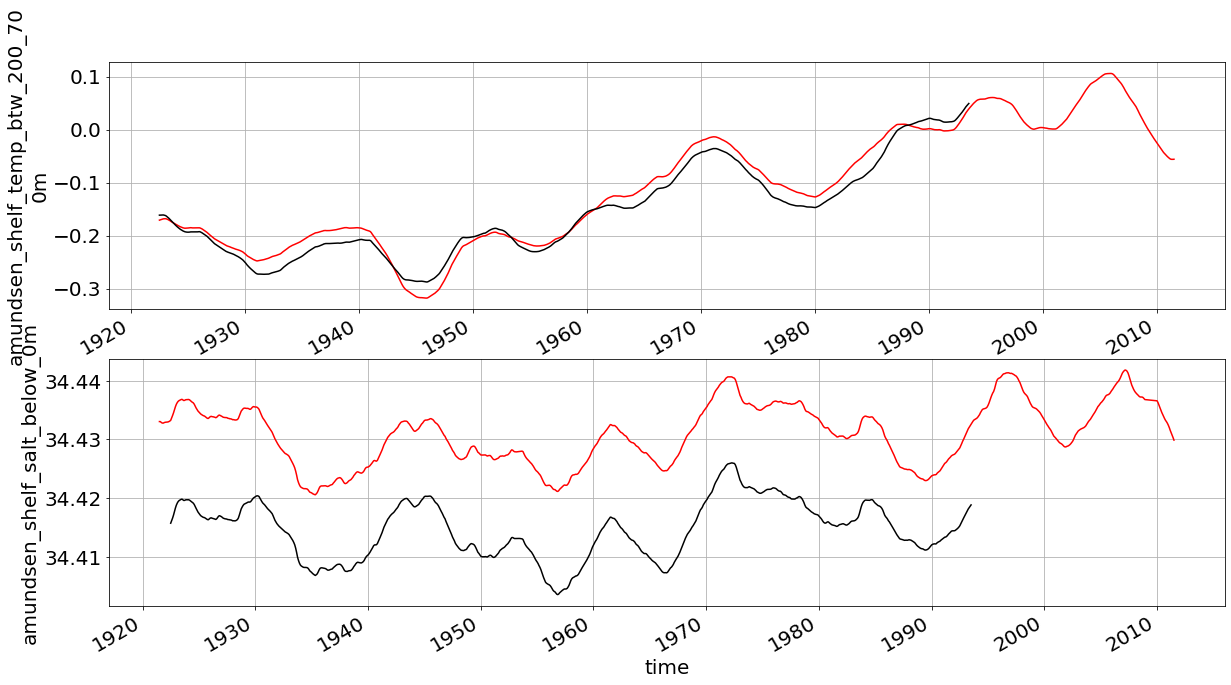

In [172]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
full['amundsen_shelf_temp_btw_200_700m'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO['amundsen_shelf_temp_btw_200_700m'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
salt['amundsen_shelf_salt_below_0m'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO['amundsen_shelf_salt_below_0m'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)


Text(0.5, 1.0, 'Change in Mean \n Velocity Norm (bottom 100m)')

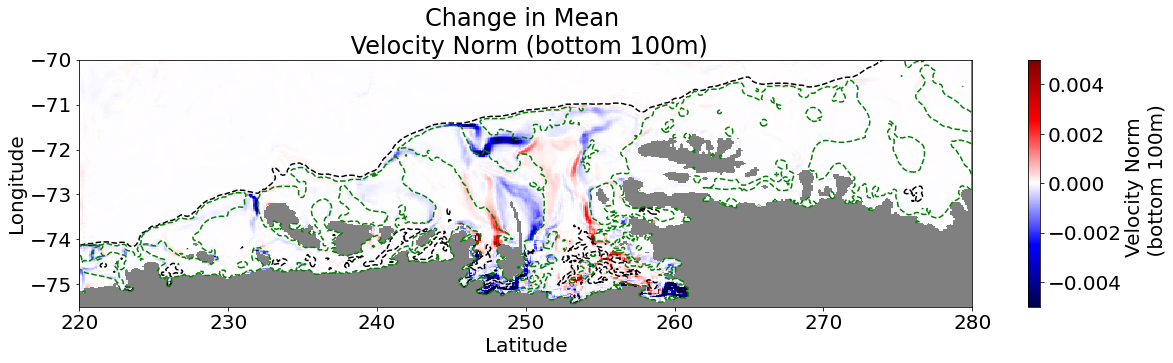

In [98]:
scale=2
step1=5
step2=5

plt.figure(figsize=(20,10))
ax=plt.subplot(2,1,2)
#ax=plt.subplot(2,1,2)
bath=ax.contour(grid.lon_2d+360, grid.lat_2d, grid.bathy, levels=[-1000, -500], colors=['black', 'green'],\
               linestyles='dashed')
plt.pcolor(GEOVEL.sel(YC=slice(-75.5, -70)).XC, GEOVEL.sel(YC=slice(-75.5, -70)).YC, \
           GEOVEL.sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens'])\
           -VEL.sel(YC=slice(-75.5, -70)).mean(dim=['time', 'ens']),
           cmap='seismic',vmax=0.005, vmin=-0.005)
plt.quiver(UVEL.sel(YC=slice(-75.5, -70)).XC[::step2], UVEL.sel(YC=slice(-75.5, -70)).YC[::step1], \
           UVELmean.values[::step1,::step2],
           VVELmean.values[::step1,::step2], scale=scale, edgecolor='w', linewidth = 0.5)

plt.colorbar(label='Velocity Norm \n (bottom 100m)')
ax.set_facecolor('grey')
ax.set_ylim([-75.5, -70])
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title('Change in Mean \n Velocity Norm (bottom 100m)')

## 1940s

In [54]:
GEO_dt=GEO.copy()
GEO_dt=GEO_dt.sel(time=slice('1920', '2013'))

full_dt=full.copy()
full_dt=full_dt.sel(time=slice('1920', '2013'))

PACEmelt_dt=PACEmelt.copy()
PACEmelt_dt=PACEmelt_dt.sel(time=slice('1920', '2013'))

for j in GEO_dt.variables:
    GEO_dt[j]=detrend_and_average_MITgcmData(GEO_dt, var=j, window=1)
for j in full_dt.variables:
    full_dt[j]=detrend_and_average_MITgcmData(full_dt, var=j, window=1)
for j in PACEmelt_dt.variables:
    PACEmelt_dt[j]=detrend_and_average_MITgcmData(PACEmelt_dt, var=j, window=1)

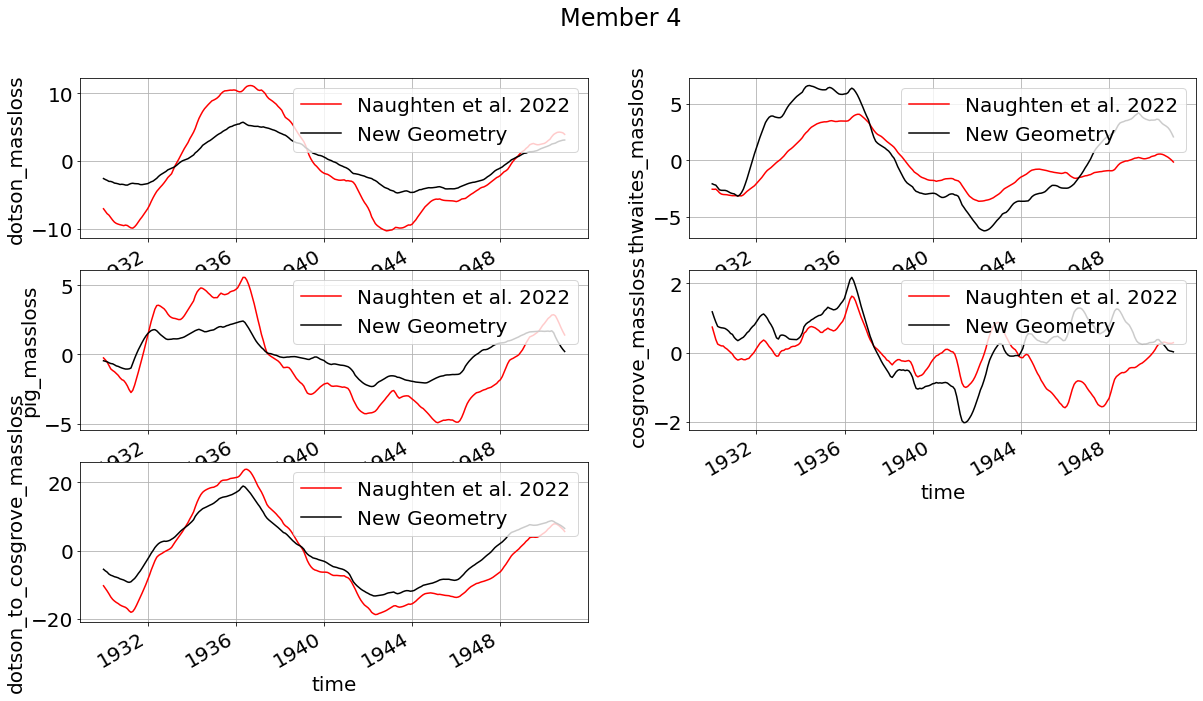

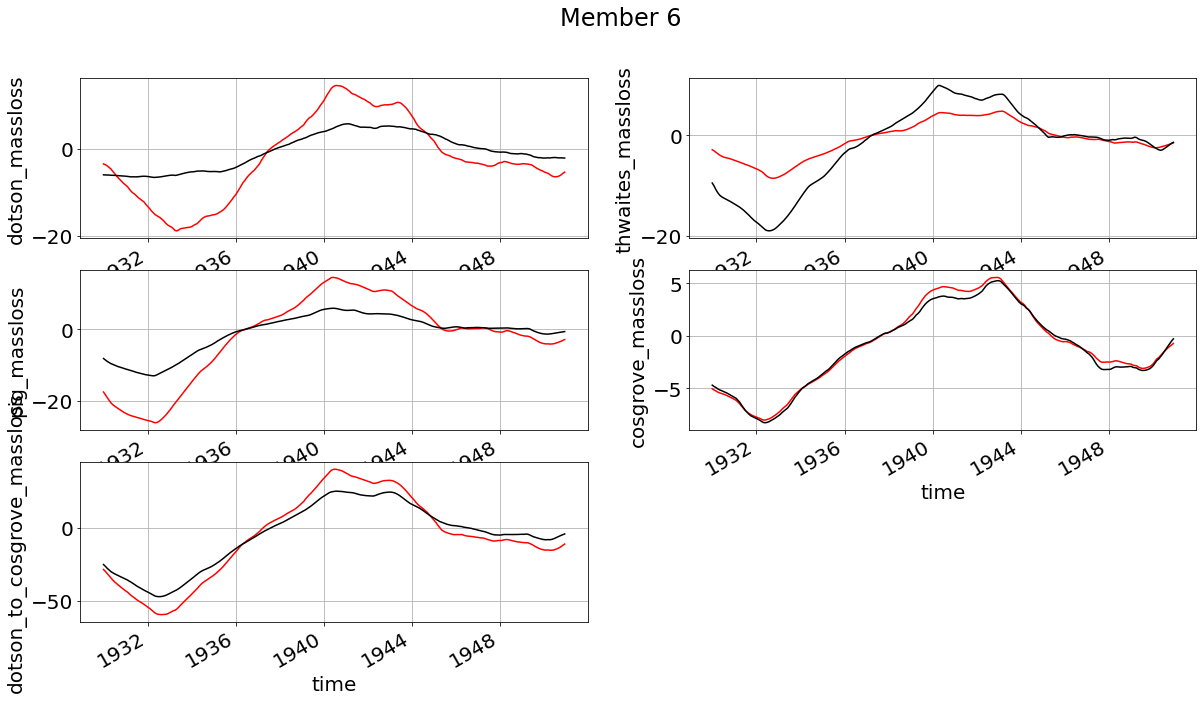

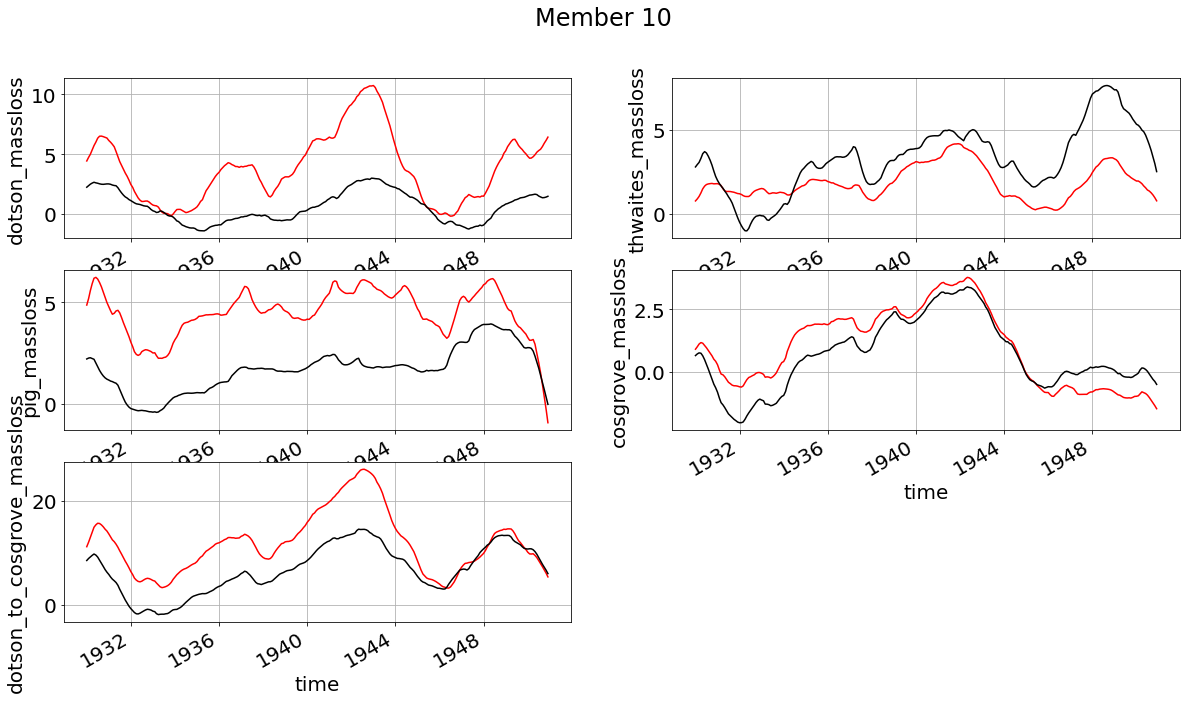

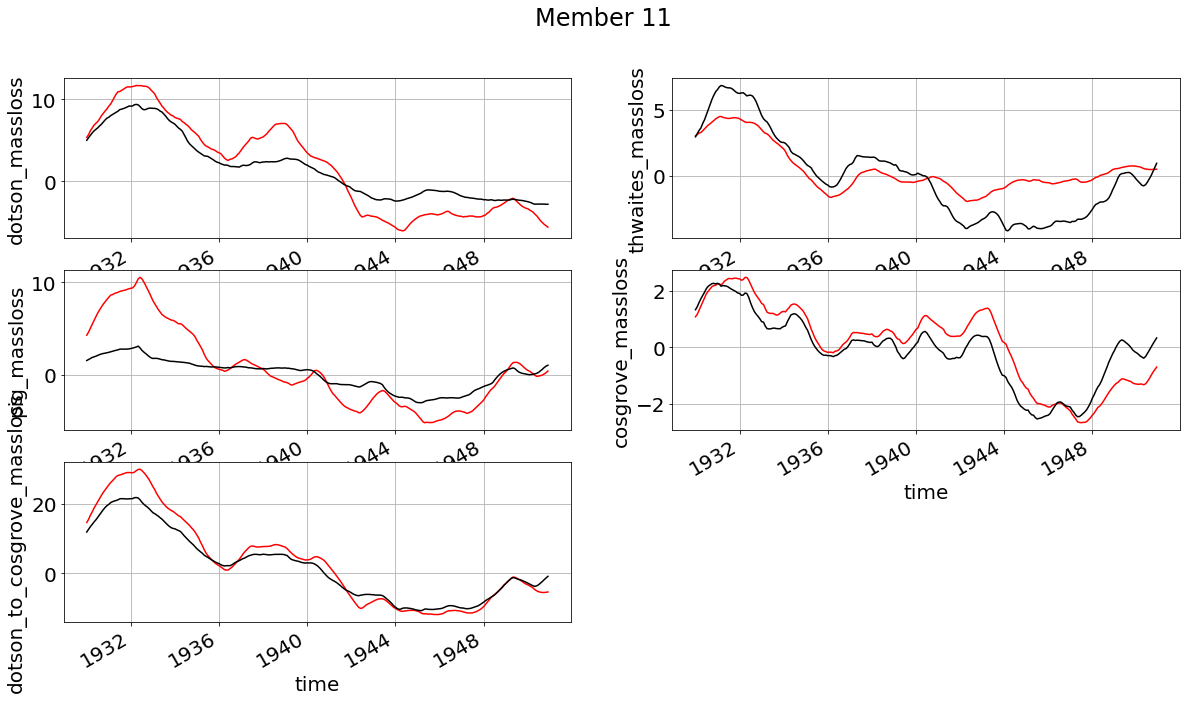

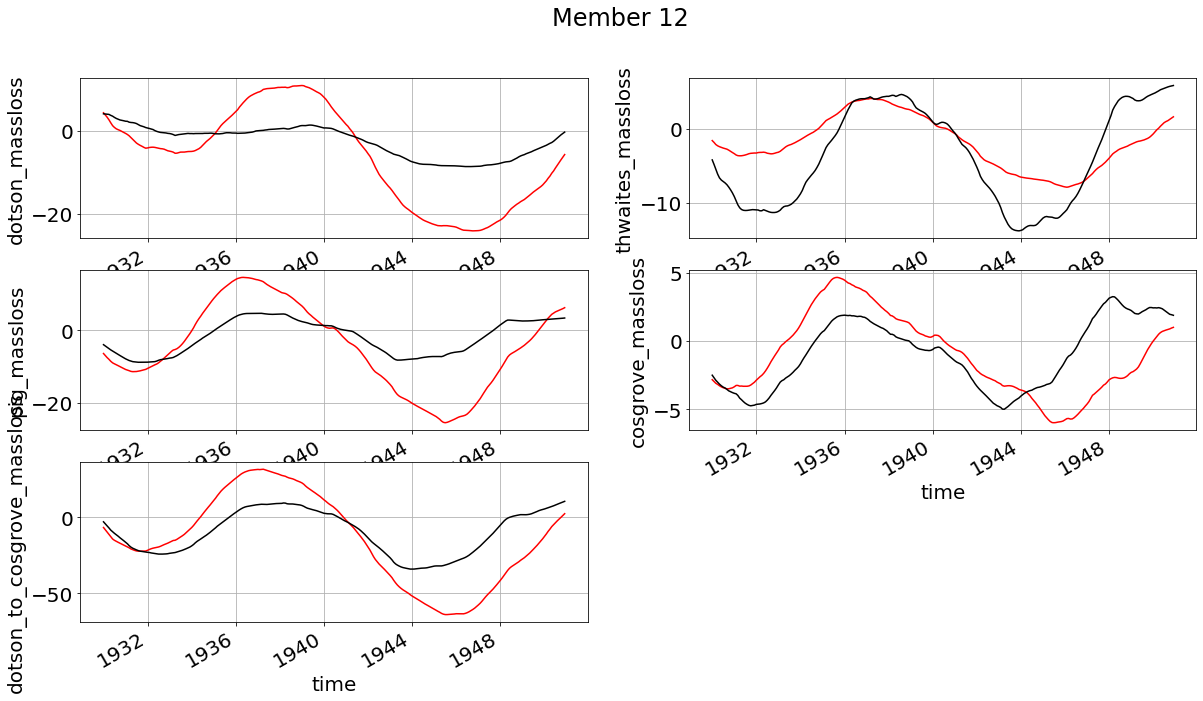

In [58]:
name=['dotson', 'thwaites',  'pig', 'cosgrove', 'dotson_to_cosgrove']
glaciername=['Dotson', 'Thwaites',  'Pine Island', 'Cosgrove', 'Dotson to Cosgrove']


for i, ens in enumerate([4,6,10,11,12]):
    plt.figure(figsize=(20,10))
    for j in range(len(name)):
        plt.subplot(3,2,j+1)
        full_dt[name[j]+'_massloss'].sel(ens=i).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean().sel(time=slice('1930', '1950'))\
        .plot(c='r', label='Naughten et al. 2022')
        GEO_dt[name[j]+'_massloss'].sel(ens=i).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean().sel(time=slice('1930', '1950'))\
        .plot(c='k', label='New Geometry')
        if i==0:
            plt.legend()
        plt.grid(True)
    plt.suptitle('Member '+str(ens))

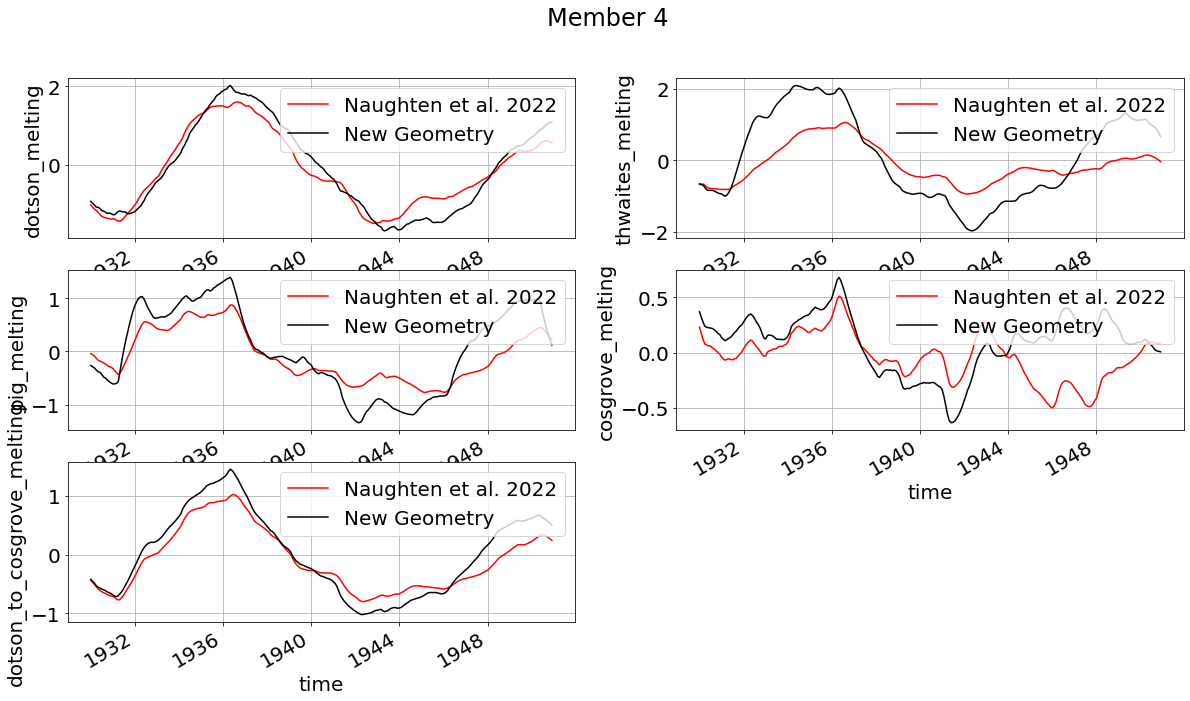

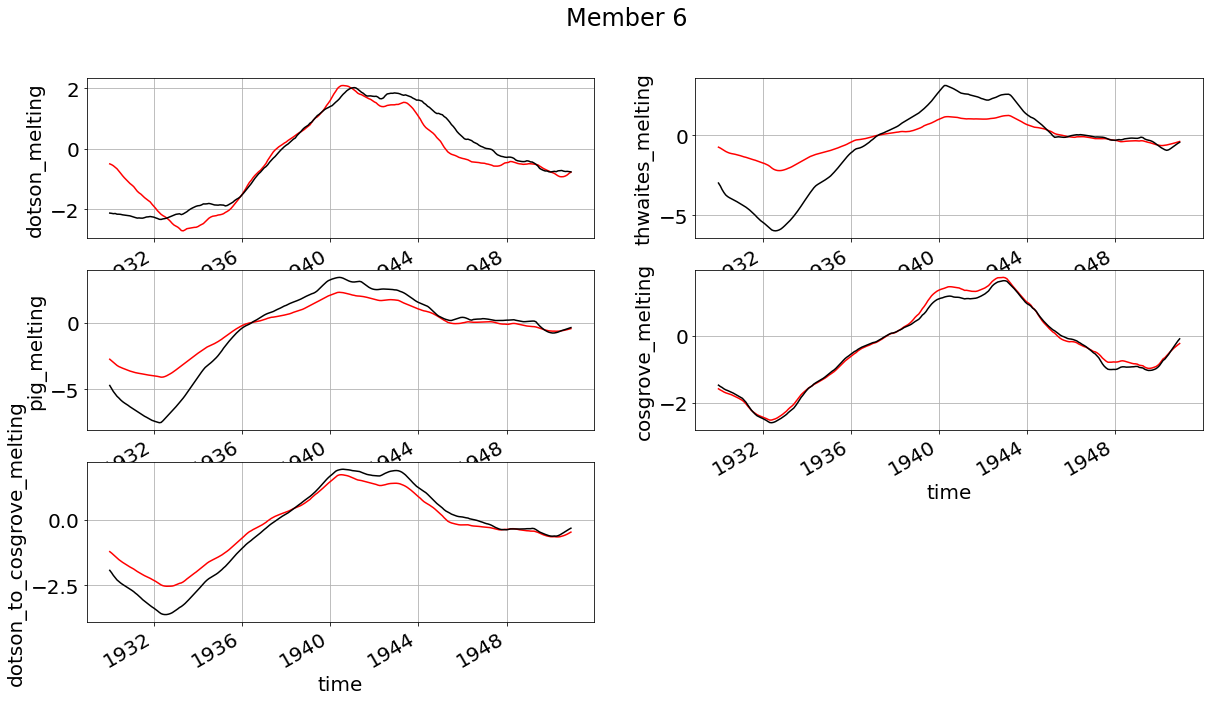

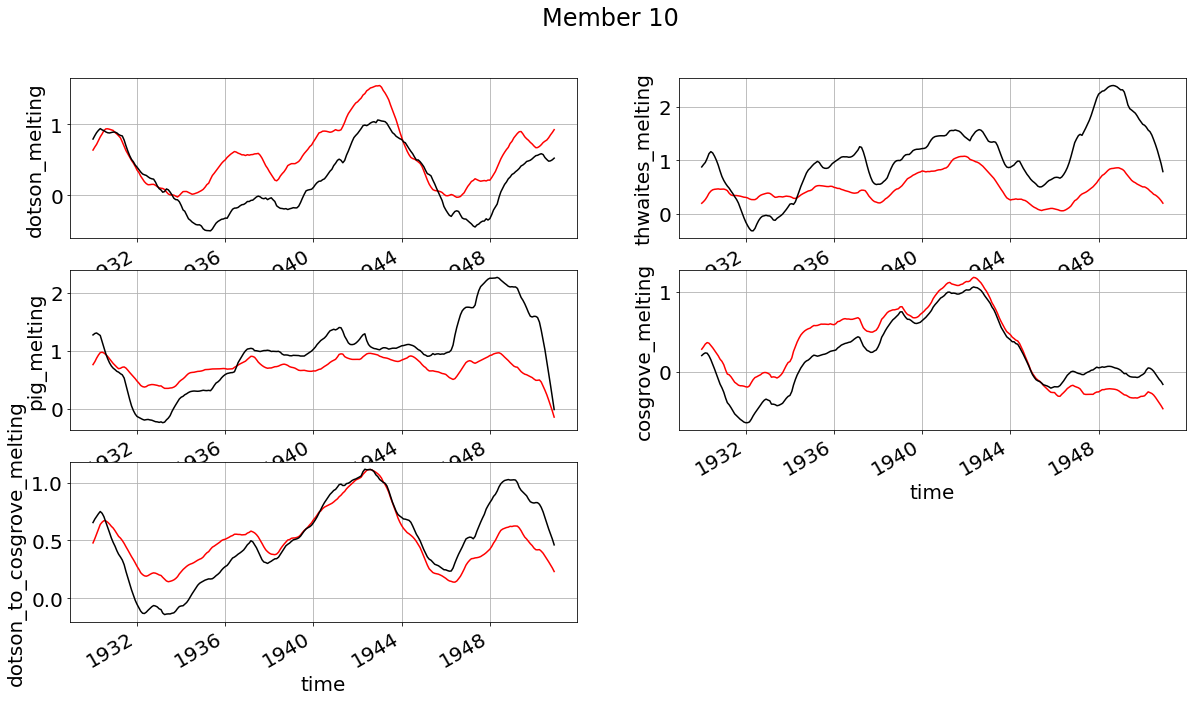

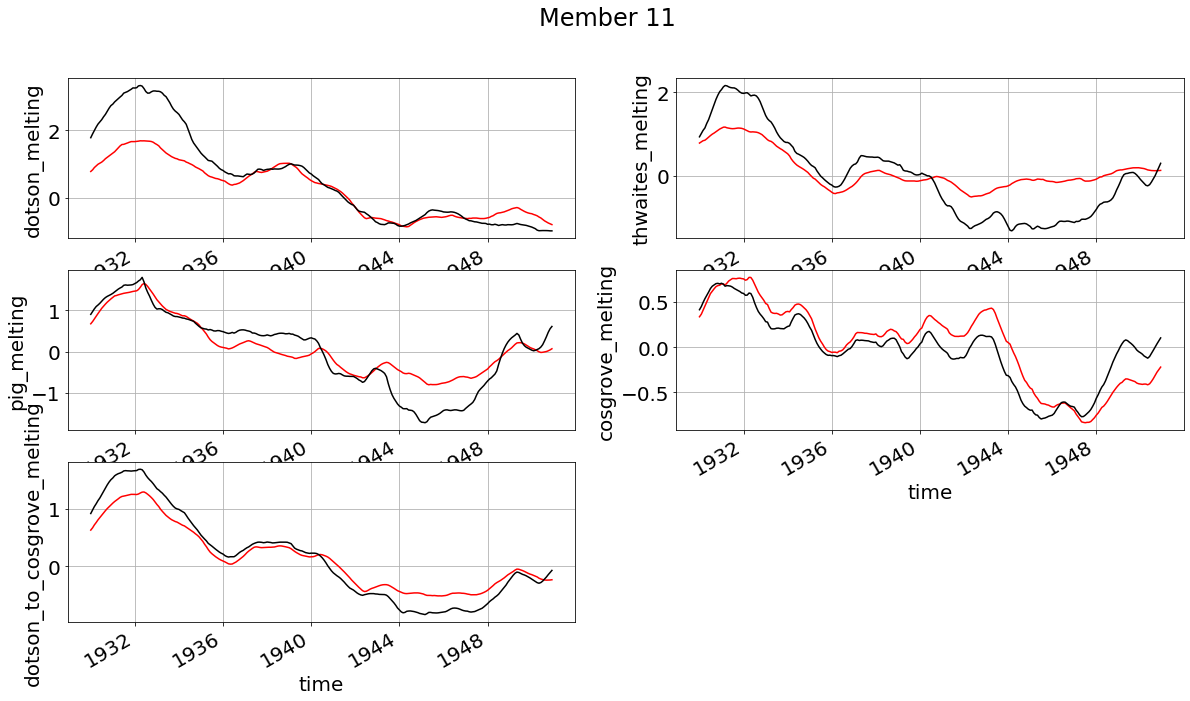

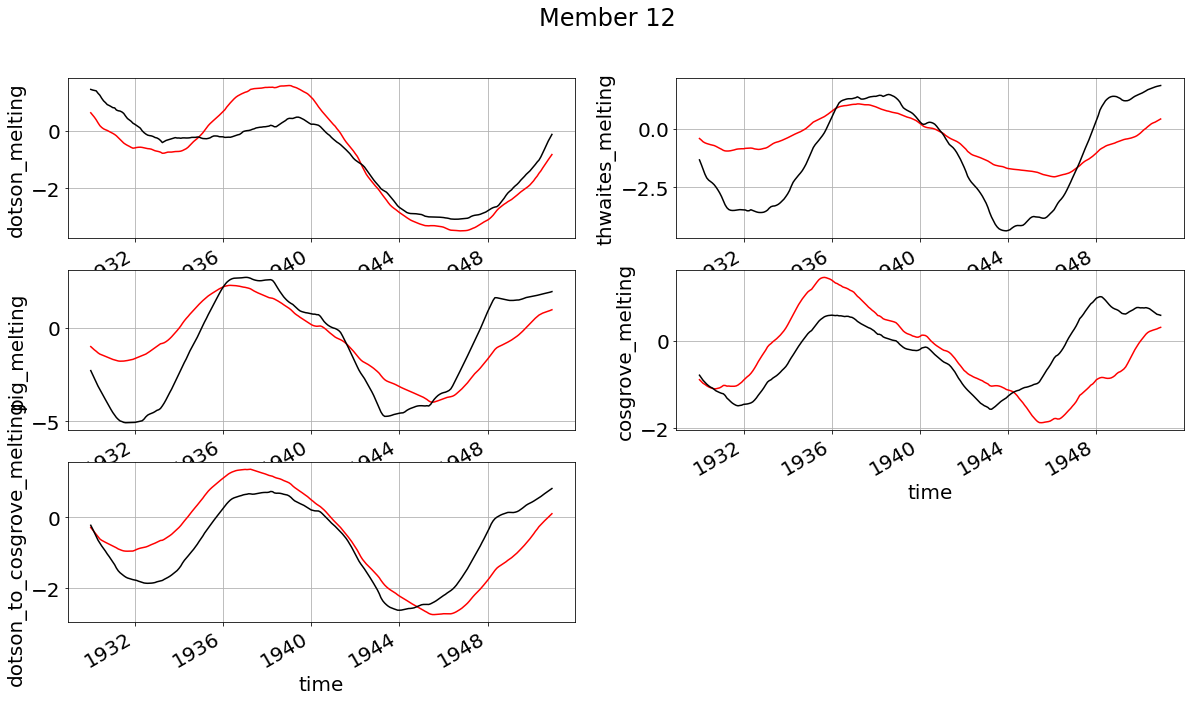

In [64]:
name=['dotson', 'thwaites',  'pig', 'cosgrove', 'dotson_to_cosgrove']
glaciername=['Dotson', 'Thwaites',  'Pine Island', 'Cosgrove', 'Dotson to Cosgrove']


for i, ens in enumerate([4,6,10,11,12]):
    plt.figure(figsize=(20,10))
    for j in range(len(name)):
        plt.subplot(3,2,j+1)
        PACEmelt_dt[name[j]+'_melting'].sel(ens=i).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean().sel(time=slice('1930', '1950'))\
        .plot(c='r', label='Naughten et al. 2022')
        GEO_dt[name[j]+'_melting'].sel(ens=i).sel(time=slice('1920', '2013'))\
        .rolling(time=window, center=True).mean().sel(time=slice('1930', '1950'))\
        .plot(c='k', label='New Geometry')
        if i==0:
            plt.legend()
        plt.grid(True)
    plt.suptitle('Member '+str(ens))

Text(0.5, 1.0, 'Melt Rate vs Mass Loss in 1940s')

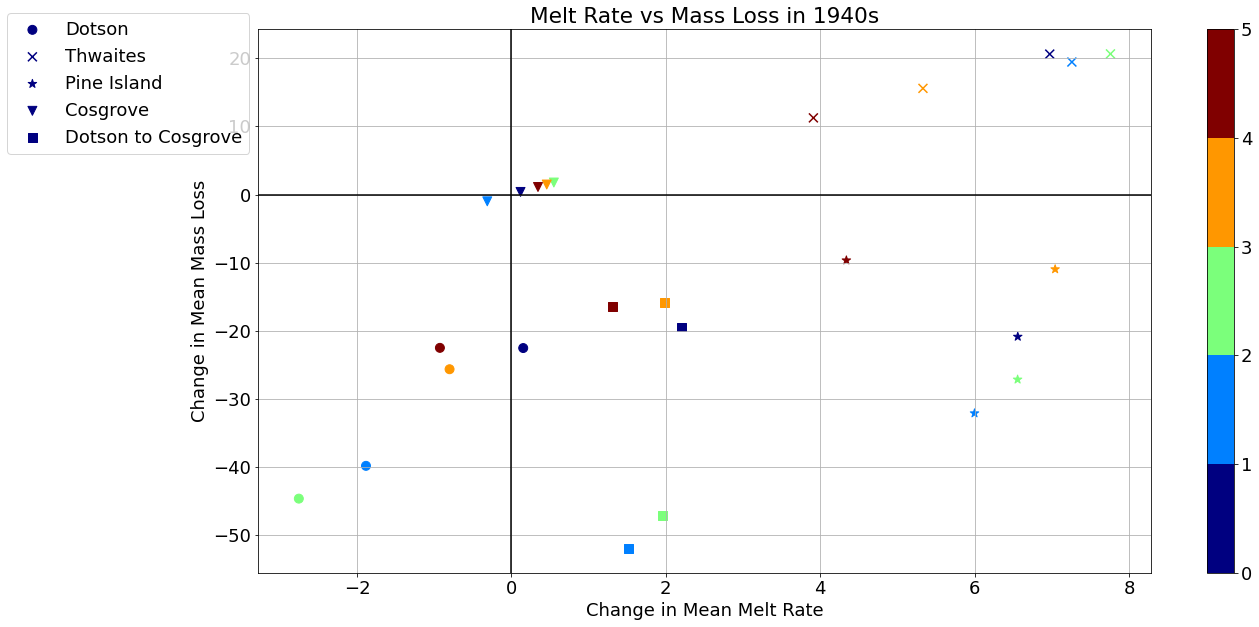

In [193]:
import matplotlib as mpl

plt.figure(figsize=(20,10))
plt.subplot(1,1,1)


GEOmean=GEO.sel(time=slice('1940', '1941')).mean(dim='time')
PACEmeltmean=PACEmelt.sel(time=slice('1940', '1941')).mean(dim='time')
fullmean=full.sel(time=slice('1940', '1941')).mean(dim='time')

c=['orange', 'red', 'blue', 'green', 'black']
m=['o', 'x', '*', 'v', 's']
glaciername=['Dotson', 'Thwaites',  'Pine Island', 'Cosgrove', 'Dotson to Cosgrove']
for i, glacier in enumerate(['dotson', 'thwaites',  'pig', 'cosgrove', 'dotson_to_cosgrove']):
    plt.scatter(GEOmean[glacier+'_melting']-PACEmeltmean[glacier+'_melting'],
               GEOmean[glacier+'_massloss']-fullmean[glacier+'_massloss'], c=GEOmean[glacier+'_massloss'].ens,
               label=glaciername[i], s=80, cmap=plt.get_cmap('jet', 5), vmin=0, vmax=5,
               marker=m[i])
plt.grid()
plt.colorbar()
plt.legend(loc='center right', bbox_to_anchor=(0, 0.9))
plt.ylabel('Change in Mean Mass Loss')
plt.xlabel('Change in Mean Melt Rate')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
#plt.xlim([-7.5, 7.5])
#plt.ylim([-40, 40])
plt.title('Melt Rate vs Mass Loss in 1940s')

Text(0.5, 0.98, 'Comparison Meltrates: Old and New Geometry')

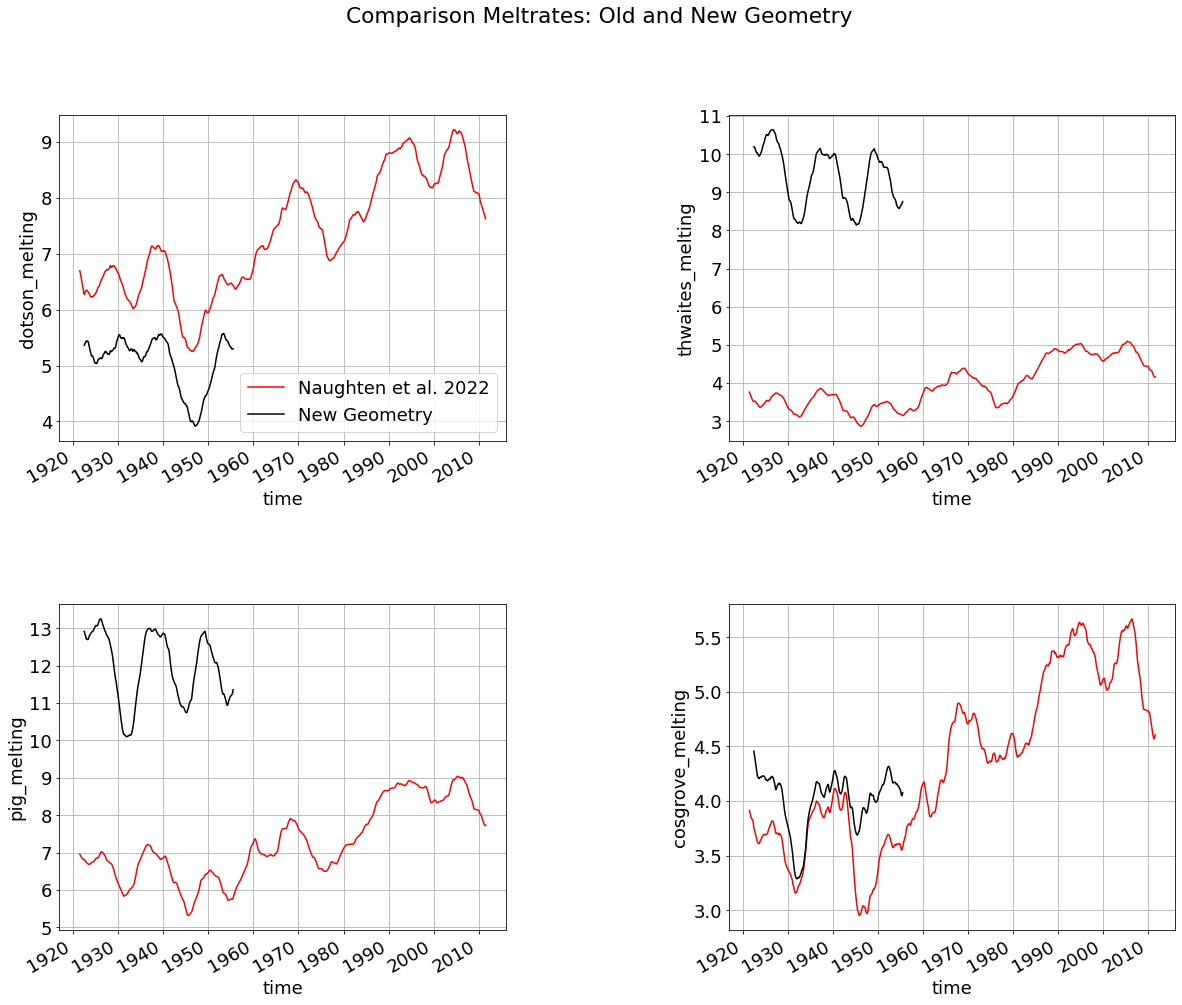

In [8]:
plt.figure(figsize=(20,15))
window=60

plt.subplot(2,2,1)
PACEmelt['dotson_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO['dotson_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
plt.legend()
plt.grid(True)


plt.subplot(2,2,2)
PACEmelt['thwaites_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO['thwaites_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
PACEmelt['pig_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO['pig_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)


plt.subplot(2,2,4)
PACEmelt['cosgrove_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO['cosgrove_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle('Comparison Meltrates: Old and New Geometry')
#plt.savefig('../03_output/new_run/comparison_meltrates_timeseries_member6.png')

In [18]:
def crosscorr(a,b, lags=np.arange(-24, 25)):
    cors=[]
    for i in lags:
        cors+=[xr.corr(a.shift(time=i),b, dim='time').values]
    return cors

In [33]:
a=PACEmelt['pig_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean()
b=GEO['pig_melting'].mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean()

In [34]:
lags=range(-24,25)
cors=crosscorr(a,b, lags=lags)

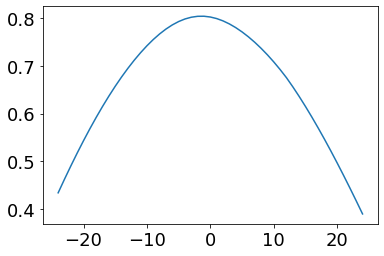

In [35]:
plt.plot(lags, cors)

In [36]:
lags[np.argmax(cors)]

-1

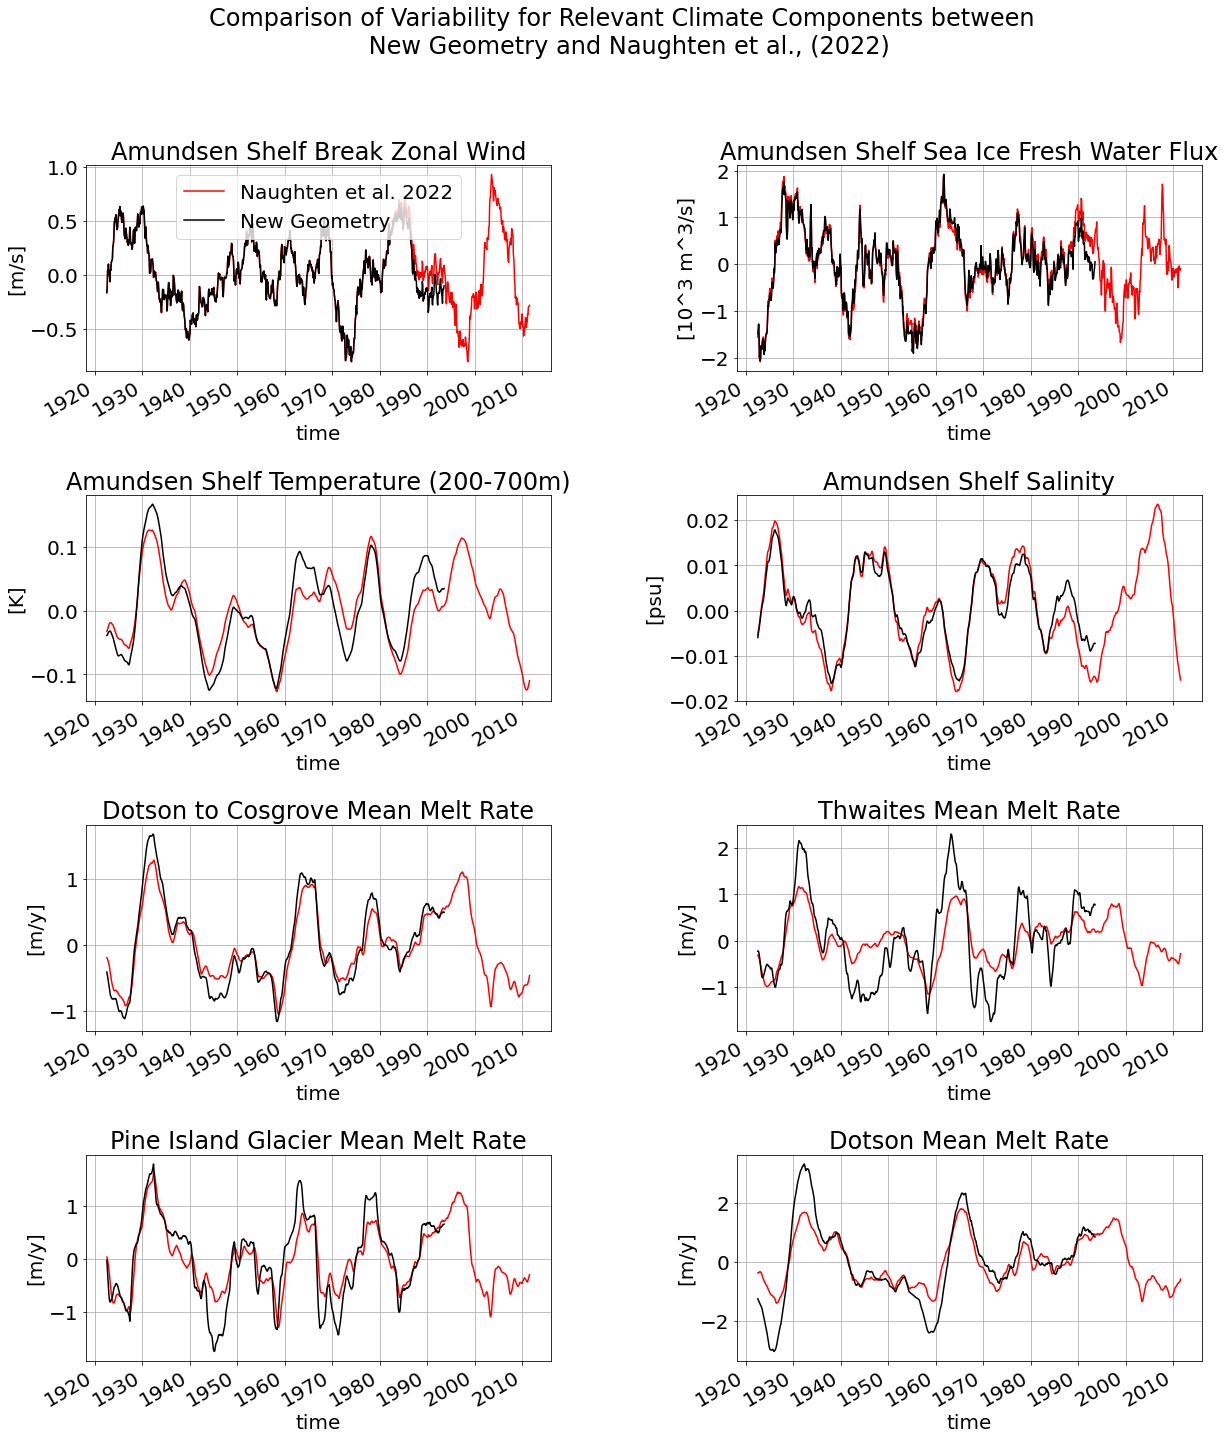

In [158]:
plt.figure(figsize=(20,22))
window=60

mem=3

plt.subplot(4,2,1)
full_dt['amundsen_shelf_break_uwind_avg'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['amundsen_shelf_break_uwind_avg'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
plt.legend()
plt.grid(True)
plt.ylabel('[m/s]')
plt.title('Amundsen Shelf Break Zonal Wind')

plt.subplot(4,2,2)
SI_dt.sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEOSI_dt.sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[10^3 m^3/s]')
plt.title('Amundsen Shelf Sea Ice Fresh Water Flux')

plt.subplot(4,2,3)
full_dt['amundsen_shelf_temp_btw_200_700m'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['amundsen_shelf_temp_btw_200_700m'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[K]')
plt.title('Amundsen Shelf Temperature (200-700m)')

plt.subplot(4,2,4)
salt_dt['amundsen_shelf_salt_below_0m'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['amundsen_shelf_salt_below_0m'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[psu]')
plt.title('Amundsen Shelf Salinity')


plt.subplot(4,2,5)
PACEmelt_dt['dotson_to_cosgrove_melting'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['dotson_to_cosgrove_melting'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Dotson to Cosgrove Mean Melt Rate')

plt.subplot(4,2,6)
PACEmelt_dt['thwaites_melting'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['thwaites_melting'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Thwaites Mean Melt Rate')

plt.subplot(4,2,7)
PACEmelt_dt['pig_melting'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['pig_melting'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Pine Island Glacier Mean Melt Rate')

plt.subplot(4,2,8)
PACEmelt_dt['dotson_melting'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='r', label='Naughten et al. 2022')
GEO_dt['dotson_melting'].sel(ens=mem).sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean().plot(c='k', label='New Geometry')
#plt.legend()
plt.grid(True)
plt.ylabel('[m/y]')
plt.title('Dotson Mean Melt Rate')

plt.suptitle('Comparison of Variability for Relevant Climate Components between \n New Geometry and Naughten et al., (2022)')
plt.subplots_adjust(hspace=0.6, wspace=0.4)

#plt.savefig('../03_output/timeseries/new_geometry_decadal_variability.png')

In [17]:
mean_new=data['SHIfwFlx'].sel(YC=slice(-75.5,-72), XC=slice(240, 265), time=slice('1920', '2013')).mean(dim='time')
mean_old=data_old['SHIfwFlx'].sel(YC=slice(-75.5,-72), XC=slice(240, 265), time=slice('1920', '2013')).mean(dim='time')

mean_new=mean_new.where(mean_new!=0, drop=False)
mean_old=mean_old.where(mean_old!=0, drop=False)

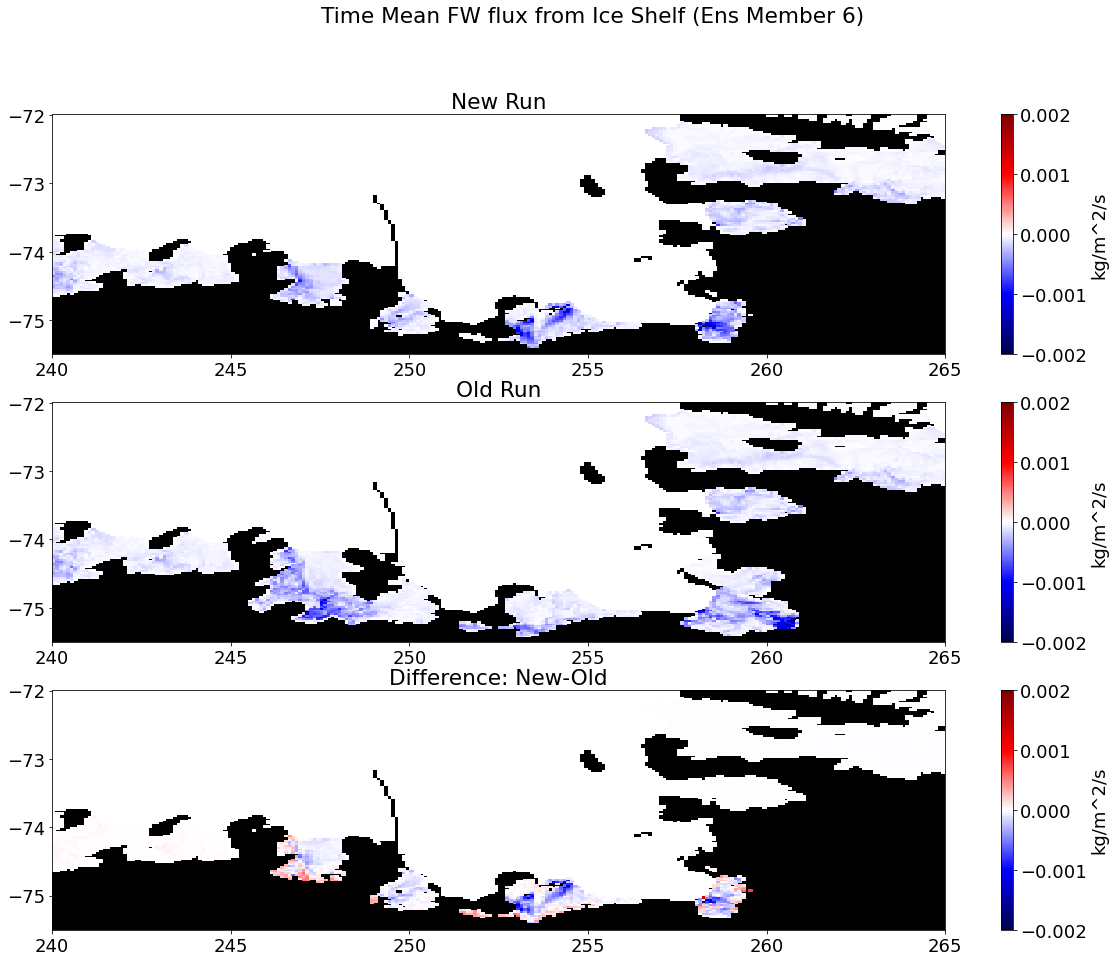

In [25]:
plt.figure(figsize=(20,15))
plt.suptitle('Time Mean FW flux from Ice Shelf (Ens Member 6)')
plt.subplot(3,1,1)
plt.title('New Run')

plt.pcolor(mean_new.XC, 
           mean_new.YC, 
           (mean_new.Depth==0),cmap='Greys')

plt.pcolor(mean_new.XC, 
           mean_new.YC, 
           mean_new,vmin=-0.002, vmax=0.002, cmap='seismic')



plt.colorbar(label='kg/m^2/s')

plt.subplot(3,1,2)
plt.title('Old Run')

plt.pcolor(mean_new.XC, 
           mean_new.YC, 
           (mean_new.Depth==0),cmap='Greys')
#frame=frame.where(frame!=0, drop=True)
plt.pcolor(mean_old.XC, 
           mean_old.YC, 
           mean_old,vmin=-0.002, vmax=0.002, cmap='seismic')
plt.colorbar(label='kg/m^2/s')

plt.subplot(3,1,3)
plt.title('Difference: New-Old')

plt.pcolor(mean_new.XC, 
           mean_new.YC, 
           (mean_new.Depth==0),cmap='Greys')
#frame=frame.where(frame!=0, drop=True)
plt.pcolor(mean_old.XC, 
           mean_old.YC, 
           mean_new-mean_old,vmin=-0.002, vmax=0.002, cmap='seismic')
plt.colorbar(label='kg/m^2/s')
                      
                                                        

## Study the New Geometry

In [4]:
import sys
import xskillscore as xs

from functions.loading_and_processing_data import loadMITgcmData, loadPACEData, detrend_and_average_MITgcmData, read_all_data, loadTimeSeriesData
sys.path.append('/data/hpcdata/users/grejan/mitgcm/') #Make sure we can also import Kaitlins code.
from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid

gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/'
grid = Grid(gp)

In [5]:
#NEW
# shelfice=np.fromfile('/data/oceans_output/shelf/grejan/archer2_mitgcm_GEO/PAS_06_GEO/output/199001/MITgcm/shelfice_new_final.bin',
#                      dtype='>f8')
# shelfice=shelfice.reshape((384,600))

# bathy=np.fromfile('/data/oceans_output/shelf/grejan/archer2_mitgcm_GEO/PAS_06_GEO/output/199001/MITgcm/bathymetry_new_final.bin',
#                    dtype='>f8')
# bathy=bathy.reshape((384,600))

shelfice=np.fromfile('/data/hpcdata/users/grejan/pahol_mitgcm/matlab/interp_PAS/data/shelfice_new_final_v3.bin',
                     dtype='>f8')
shelfice=shelfice.reshape((384,600))

bathy=np.fromfile('/data/hpcdata/users/grejan/pahol_mitgcm/matlab/interp_PAS/\
data/bathymetry_new_final_v3.bin',
                   dtype='>f8')
bathy=bathy.reshape((384,600))


#OLD
shelfice_old=np.fromfile('/data/hpcdata/users/grejan/pahol_mitgcm/matlab/interp_PAS/data/shelfice_ARCHER.bin',
                     dtype='>f8')
shelfice_old=shelfice_old.reshape((384,600))

bathy_old=np.fromfile('/data/hpcdata/users/grejan/pahol_mitgcm/matlab/interp_PAS/data/bathymetry_bedmach_ARCHER.bin',
                   dtype='>f8')
bathy_old=bathy_old.reshape((384,600))

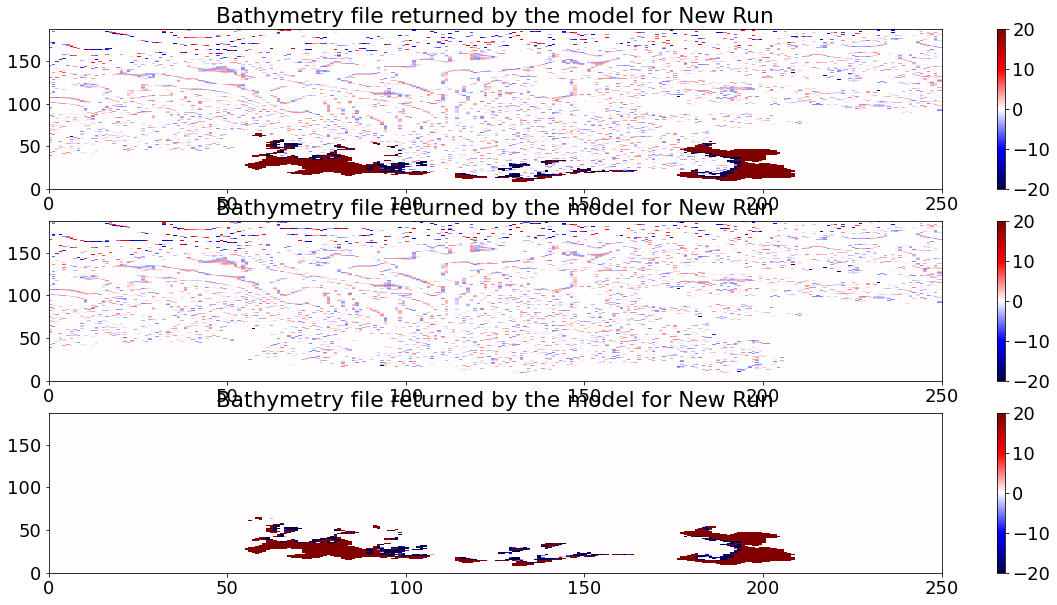

In [6]:
plt.figure(figsize=(20,10))

diff=bathy-grid.bathy
plt.subplot(3,1,1)
plt.title('Bathymetry file returned by the model for New Run')
plt.pcolor(diff[:187,200:450], cmap='seismic', vmin=-20, vmax=20)
plt.colorbar()

diff=bathy_old-grid.bathy
plt.subplot(3,1,2)
plt.title('Bathymetry file returned by the model for New Run')
plt.pcolor(diff[:187,200:450], cmap='seismic', vmin=-20, vmax=20)
plt.colorbar()

diff=bathy-bathy_old
plt.subplot(3,1,3)
plt.title('Bathymetry file returned by the model for New Run')
plt.pcolor(diff[:187,200:450], cmap='seismic', vmin=-20, vmax=20)
plt.colorbar()


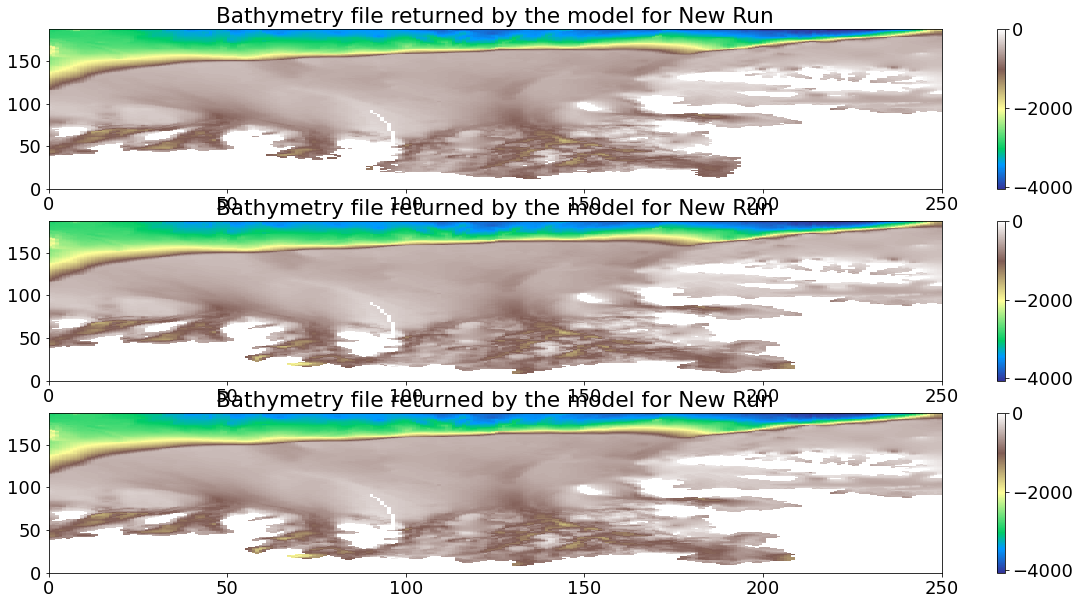

In [7]:
plt.figure(figsize=(20,10))

diff=bathy
plt.subplot(3,1,1)
plt.title('Bathymetry file returned by the model for New Run')
plt.pcolor(diff[:187,200:450], cmap='terrain')
plt.colorbar()

diff=grid.bathy
plt.subplot(3,1,2)
plt.title('Bathymetry file returned by the model for New Run')
plt.pcolor(diff[:187,200:450], cmap='terrain')
plt.colorbar()

diff=bathy_old
plt.subplot(3,1,3)
plt.title('Bathymetry file returned by the model for New Run')
plt.pcolor(diff[:187,200:450], cmap='terrain')
plt.colorbar()

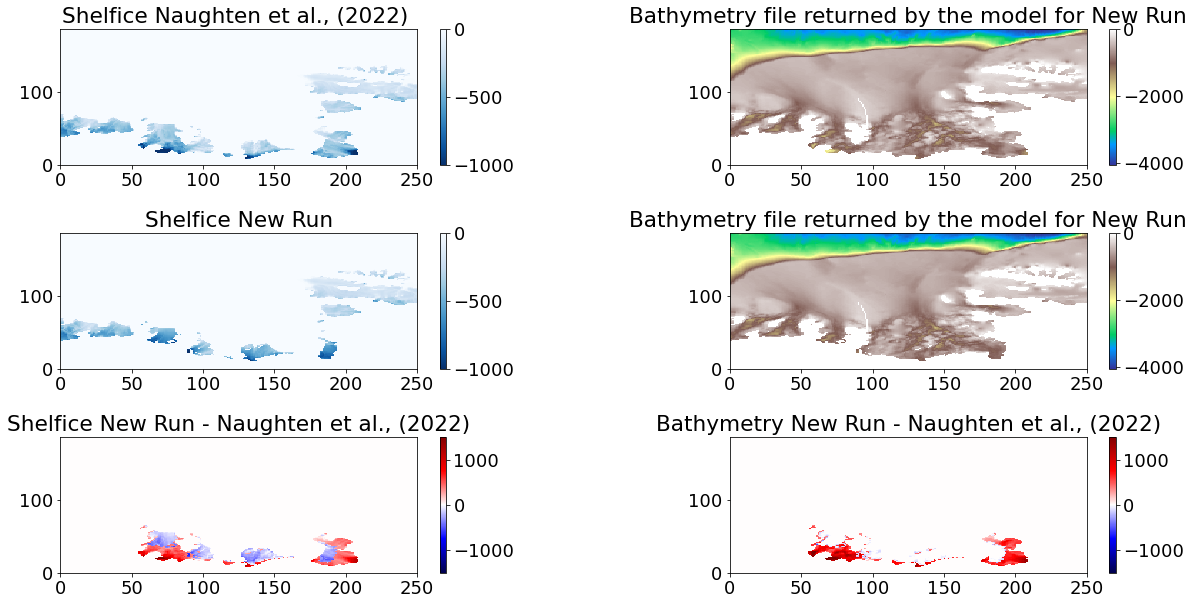

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
plt.title('Shelfice Naughten et al., (2022) ')
plt.pcolor(shelfice_old[:187,200:450], cmap='Blues_r', vmin=-1000, vmax=0)
plt.colorbar()

plt.subplot(3,2,2)
plt.title('Bathymetry file returned by the model for New Run')
plt.pcolor((bathy_old)[:187,200:450], cmap='terrain')
plt.colorbar()

plt.subplot(3,2,3)
plt.title('Shelfice New Run')
plt.pcolor((shelfice)[:187,200:450], cmap='Blues_r', vmin=-1000, vmax=0)
plt.colorbar()

plt.subplot(3,2,4)
plt.title('Bathymetry file returned by the model for New Run')
plt.pcolor((bathy)[:187,200:450], cmap='terrain')
plt.colorbar()

plt.subplot(3,2,5)
plt.title('Shelfice New Run - Naughten et al., (2022)')
plt.pcolor((shelfice)[:187,200:450]-shelfice_old[:187,200:450], cmap='seismic', vmin=-1500, vmax=1500)
plt.colorbar()

plt.subplot(3,2,6)
plt.title('Bathymetry New Run - Naughten et al., (2022)')
plt.pcolor(bathy[:187,200:450]-bathy_old[:187,200:450], cmap='seismic', vmin=-1500, vmax=1500)
plt.colorbar()

plt.subplots_adjust(hspace=0.5, wspace=0.5)


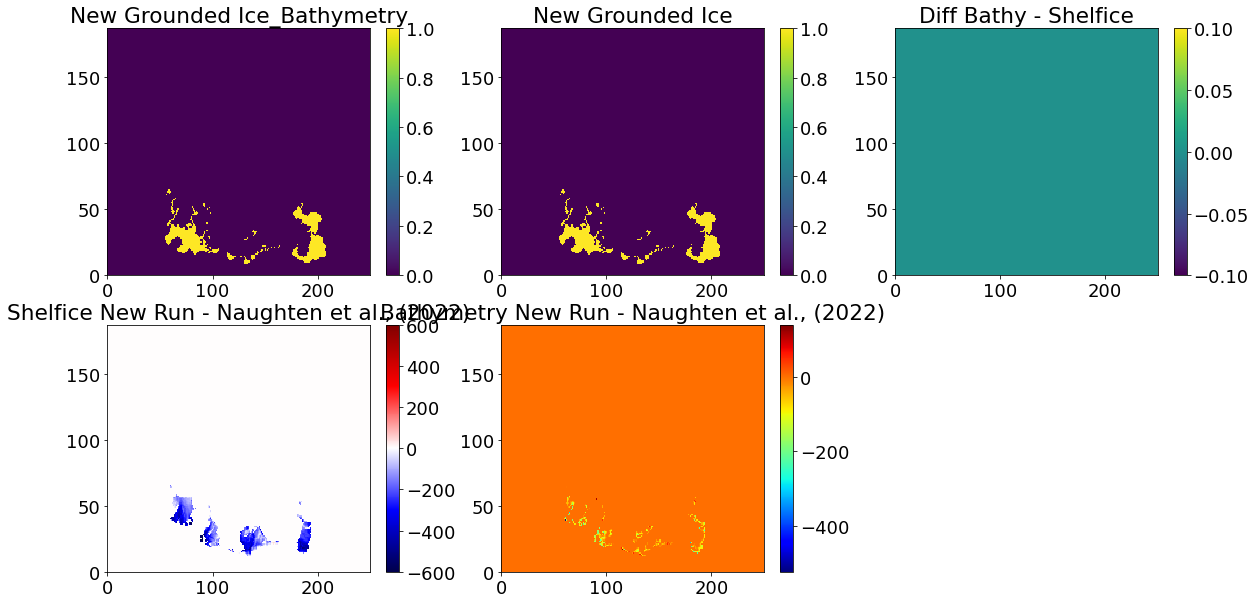

In [7]:
#New Grounded Ice
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.title('New Grounded Ice_Bathymetry')
new_grounded=np.zeros(np.shape(bathy))
new_grounded[(bathy==0) & (bathy_old!=0)]=True

plt.pcolor(new_grounded[:187,200:450])
plt.colorbar()

plt.subplot(2,3,2)
plt.title('New Grounded Ice')
new_grounded2=np.zeros(np.shape(shelfice))
new_grounded2[(shelfice==0) & (shelfice_old!=0)]=True

plt.pcolor(new_grounded2[:187,200:450])
plt.colorbar()


plt.subplot(2,3,3)
plt.title('Diff Bathy - Shelfice')

plt.pcolor((new_grounded-new_grounded2)[:187,200:450])
plt.colorbar()


plt.subplot(2,3,4)
plt.title('Shelfice New Run - Naughten et al., (2022)')
SI_diff=shelfice-shelfice_old
SI_diff[new_grounded2.astype(bool)]=0
plt.pcolor(SI_diff[:187,200:450], cmap='seismic', vmin=-600, vmax=600)
plt.colorbar()

plt.subplot(2,3,5)
plt.title('Bathymetry New Run - Naughten et al., (2022)')
BA_diff=bathy-bathy_old
BA_diff[new_grounded.astype(bool)]=0
plt.pcolor(BA_diff[:187,200:450], cmap='jet')
plt.colorbar()

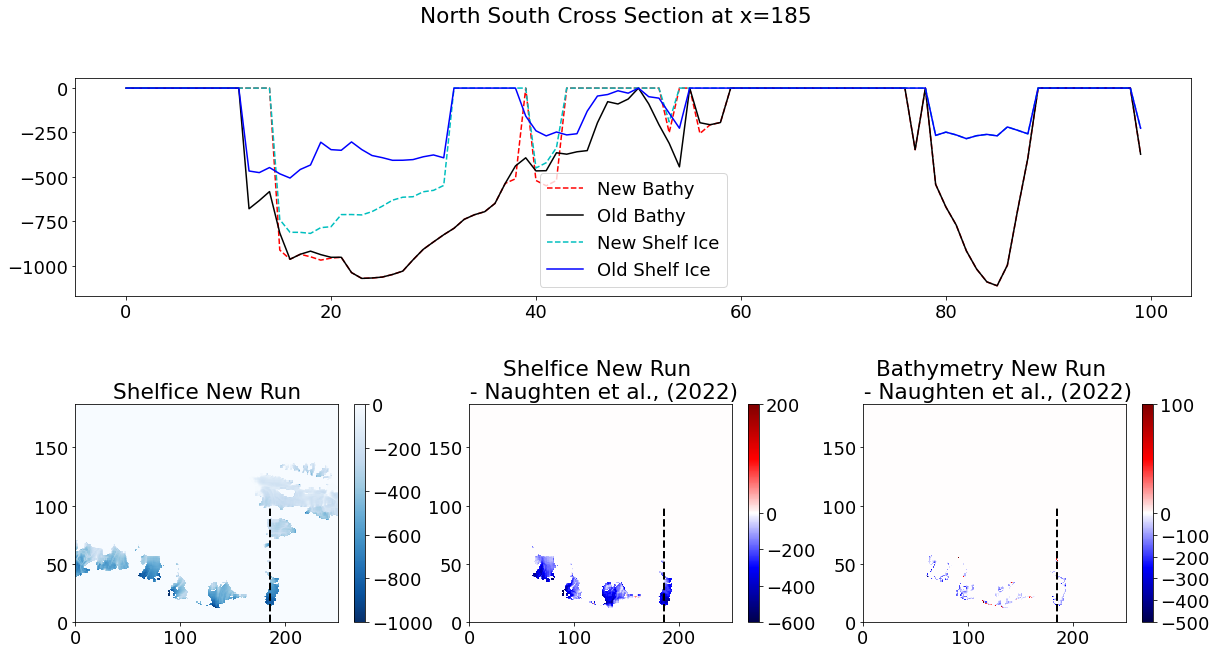

In [8]:
#x=80
# y=100

x=185
y=100

#Where dit bathymetry increase?
#x=160
#x=115
#y=40

plt.figure(figsize=(20,10))
plt.suptitle('North South Cross Section at x='+str(x))
plt.subplot(2,1,1)
plt.plot(bathy[:187,200:450][:y,x], '--r', label='New Bathy')
plt.plot(bathy_old[:187,200:450][:y,x], '-k', label='Old Bathy')

#plt.subplot(2,1,2)
plt.plot(shelfice[:187,200:450][:y,x], '--c', label='New Shelf Ice')
plt.plot(shelfice_old[:187,200:450][:y,x], 'b', label='Old Shelf Ice')
plt.legend()

plt.subplot(2,3,4)
plt.title('Shelfice New Run')
plt.pcolor((shelfice)[:187,200:450], cmap='Blues_r', vmin=-1000, vmax=0)
plt.colorbar()
plt.plot([x, x], [0,y], lw=2, c='k', ls='--')


plt.subplot(2,3,5)
plt.title('Shelfice New Run \n - Naughten et al., (2022)')
SI_diff=shelfice-shelfice_old
SI_diff[new_grounded2.astype(bool)]=0
plt.pcolor(SI_diff[:187,200:450], cmap='seismic', norm=colors.TwoSlopeNorm(vmin=-600., vcenter=0, vmax=200))
plt.colorbar()
plt.plot([x, x], [0,y], lw=2, c='k', ls='--')

plt.subplot(2,3,6)
plt.title('Bathymetry New Run \n - Naughten et al., (2022)')
BA_diff=bathy-bathy_old
BA_diff[new_grounded.astype(bool)]=0
plt.pcolor(BA_diff[:187,200:450], cmap='seismic', norm=colors.TwoSlopeNorm(vmin=-500., vcenter=0, vmax=100))
plt.colorbar()
plt.plot([x, x], [0,y], lw=2, c='k', ls='--')

plt.subplots_adjust(hspace=0.5)

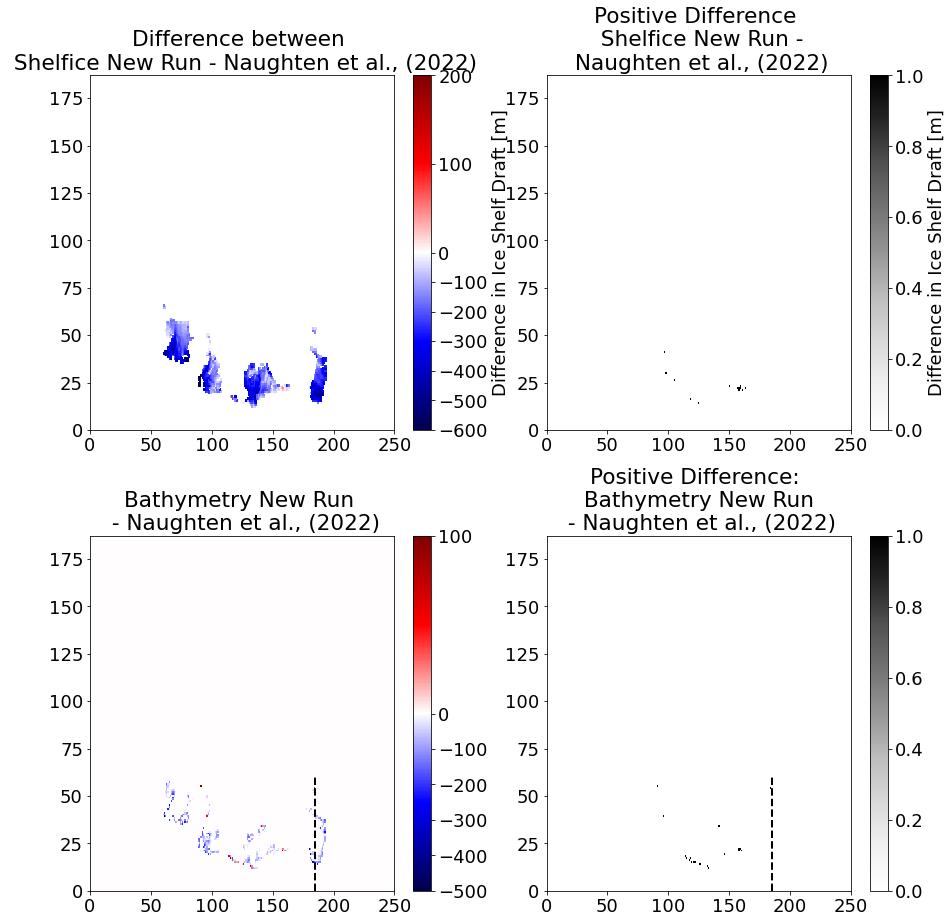

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('Difference between \n Shelfice New Run - Naughten et al., (2022)')
SI_diff=shelfice-shelfice_old
SI_diff[new_grounded2.astype(bool)]=0
bg=bathy.copy()
bg[bg!=0]=np.nan
SI_diff[SI_diff==0]=np.nan
plt.pcolor(SI_diff[:187,200:450], cmap='seismic', norm=colors.TwoSlopeNorm(vmin=-600., vcenter=0, vmax=200))
plt.colorbar(label='Difference in Ice Shelf Draft [m]')


plt.subplot(2,2,2)
plt.title('Positive Difference \n  Shelfice New Run - \n Naughten et al., (2022)')
SI_diff=shelfice-shelfice_old
SI_diff[new_grounded2.astype(bool)]=0
bg=bathy.copy()
bg[bg!=0]=np.nan
SI_diff[SI_diff==0]=np.nan
plt.pcolor(SI_diff[:187,200:450], cmap='seismic', norm=colors.TwoSlopeNorm(vmin=-600., vcenter=0, vmax=200))
plt.pcolor((SI_diff>0)[:187,200:450], cmap='Greys')

plt.colorbar(label='Difference in Ice Shelf Draft [m]')

#plt.pcolor(bg[:187,200:450], cmap='Greys_r')#, norm=colors.TwoSlopeNorm(vmin=-600., vcenter=0, vmax=200))
#plt.plot([x, x], [0,y], lw=2, c='k', ls='--')

plt.subplot(2,2,3)
plt.title('Bathymetry New Run \n - Naughten et al., (2022)')
BA_diff=bathy-bathy_old
BA_diff[new_grounded.astype(bool)]=0
plt.pcolor(BA_diff[:187,200:450], cmap='seismic', norm=colors.TwoSlopeNorm(vmin=-500., vcenter=0, vmax=100))
plt.colorbar()
plt.subplots_adjust(hspace=0.3)
x=185
y=60
plt.plot([x, x], [0,y], lw=2, c='k', ls='--')


plt.subplot(2,2,4)
plt.title('Positive Difference: \n Bathymetry New Run \n - Naughten et al., (2022)')
BA_diff=bathy-bathy_old
BA_diff[new_grounded.astype(bool)]=0
plt.pcolor((BA_diff>0)[:187,200:450], cmap='Greys')
plt.colorbar()
plt.subplots_adjust(hspace=0.3)
x=185
y=60
plt.plot([x, x], [0,y], lw=2, c='k', ls='--')